# Patially Linear IV models using Double Machine Learning

Version without lagged demand

In [1]:
# import necessary packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.api
import scipy
import statsmodels
from sklearn.base import clone
import doubleml as dml
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV, Lasso,LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_rows = 4000
pd.options.display.max_columns = 4000

In [2]:
#import transformed dataset that's ready for use
df_log=pd.read_csv("dataframe_transformed_4_log.csv")

In [3]:
len(df_log)

67911

In [4]:
#Some additional transformations:

# The zero demand observations become -infinity because of the log-transformation
# These values should be deleted or replaced:
    # the observations with zero demand will be deleted, however in the lagged demand variable this data is still needed
    # So choose a value to impute these -infinity values with: Preferably np.NaN such that no bias will occur

# Based on what first stage method you will use, it may or may not be able to handle missing values. 
# Create an imputed value for the methods that cannot use NaNs
# Here: the missing values are most often referring to a promo period, hence a MAX value for demand is imputed to act as a surrogate for this promo demand.


# Include dummy variab;e for holidays and other special dates that can explain irregular demand
listofHolidays=["2020-12-28",
                "2021-01-04",
                "2021-03-29",
                "2021-05-03",
                "2021-07-26",
                "2021-08-02",
                "2021-08-09",
                "2021-08-16",
                "2021-12-27",
                "2022-01-03",
                "2022-04-11",
                "2022-05-02",
                "2022-07-25",
                "2022-08-01",
                "2022-08-08",
                "2022-08-15",
                "2022-12-26"
                ]
df_log['HOLIDAY']=(df_log['WEEK_START_DATE'].isin(listofHolidays))*1

# non-log-transformed week number (do not need log-interpretatation of this variable ("percentage increase in week number leads to percentage change in demand or price" --> should be "absolute change in weeks lead to percentage change demand/price")
# (inflation measure)
df_log['WEEK_NR']=np.round(np.exp(df_log['L_WEEK_NR']))

Model set up: create datasets


In [5]:
x_lasso= df_log[['CONST','ARTICLE_TIER_BETTER', 'ARTICLE_TIER_GOOD',
       'ART_BRAND_TIER_PRICE_ENTRY', 'ART_BRAND_TIER_PRIVATE_LABEL',
       'PACKAGING_BOX', 'PACKAGING_CAN', 'PACKAGING_PACK',
       'ARTICLE_CAT_2_DRINKPAKJES', 'ARTICLE_CAT_2_FRUITDRANK',
       'ARTICLE_CAT_2_IJSTHEE', 'ARTICLE_CAT_2_LIMONADE_SIROPEN',
       'ARTICLE_CAT_2_SAPPEN_SMOOTHIES', 'ARTICLE_CAT_2_SINAS_LEMON_CASSIS',
       'ARTICLE_CAT_2_SPECIAAL_FRIS', 'ARTICLE_CAT_2_SPORT_ENERGYDRINK',
       'ARTICLE_CAT_2_WATER', 
       'PROMO_DUMMY', 
       'PPL2','PPL3', 'POSTPPL1', 'POSTPPL2','POSTPPL3', 
       'L_AVG_HIGH_TEMP',#'L_TOTAL_ORDER_AMT',
       'L_NR_ARTICLES_IN_CAT', 
       'L_NR_ARTICLES_IN_CAT_2',  #'L_WEEK_NR',
       'AVG_UNAVAILABILITY_PERC',
       'ART_CONTENT_VOLUME', 'ART_IS_MULTIPACK', 
       # 'L_PRODUCT_ORDER_AMT_T_2_m','L_PRODUCT_ORDER_AMT_T_1_m' , # use imputed value instead of NaN
       # 'L_PRODUCT_ORDER_AMT_T_1', 'L_PRODUCT_ORDER_AMT_T_2',
       'HOLIDAY', 'WEEK_NR'
       ]]
y_lasso = df_log['L_PRODUCT_ORDER_AMT']
p_lasso = df_log['L_AVG_SELL_PRICE']
z_lasso = df_log['L_AVG_PURCHASE_PRICE']

naiveset_lasso=x_lasso.join(p_lasso.to_frame()) # For OLS
dmlset_lasso=x_lasso.join(y_lasso.to_frame().join(p_lasso.to_frame().join(z_lasso.to_frame()))) #needed in dml algortihm

In [6]:
x_lasso_train, x_lasso_test, y_lasso_train, y_lasso_test, p_lasso_train, p_lasso_test, z_lasso_train, z_lasso_test, naiveset_lasso_train, naiveset_lasso_test, dmlset_lasso_train, dmlset_lasso_test = train_test_split(x_lasso,y_lasso,p_lasso,z_lasso,naiveset_lasso, dmlset_lasso,random_state=44) #in case want to see how first stages perform

Naive models:


OLS:

In [7]:
from linearmodels.iv import IV2SLS
# IV2SLS(dependent:,exog:,endog:,instru:,weights:)

res_ols = IV2SLS(y_lasso_train, naiveset_lasso_train, None, None).fit(cov_type="unadjusted")
res_ols

OLS Estimation Summary                            
===============================================================================
Dep. Variable:     L_PRODUCT_ORDER_AMT   R-squared:                      0.3529
Estimator:                         OLS   Adj. R-squared:                 0.3525
No. Observations:                50933   F-statistic:                 2.778e+04
Date:                 Wed, Mar 29 2023   P-value (F-stat)                0.0000
Time:                         10:11:42   Distribution:                 chi2(31)
Cov. Estimator:             unadjusted                                         
                                                                               
                                        Parameter Estimates                                         
====================================================================================================
                                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------------------------
CONST                                29.209     1.0434     27.996     0.0000      27.165      31.254
ARTICLE_TIER_BETTER                  0.3401     0.0172     19.778     0.0000      0.3064      0.3738
ARTICLE_TIER_GOOD                    1.0142     0.0339     29.941     0.0000      0.9478      1.0806
ART_BRAND_TIER_PRICE_ENTRY          -1.0437     0.0578    -18.062     0.0000     -1.1570     -0.9305
ART_BRAND_TIER_PRIVATE_LABEL        -0.5907     0.0244    -24.234     0.0000     -0.6384     -0.5429
PACKAGING_BOX                        1.5100     0.0578     26.105     0.0000      1.3966      1.6233
PACKAGING_CAN                        0.3553     0.0637     5.5737     0.0000      0.2304      0.4803
PACKAGING_PACK                       0.4160     0.0205     20.328     0.0000      0.3759      0.4561
ARTICLE_CAT_2_DRINKPAKJES           -2.0951     0.0831    -25.199     0.0000     -2.2580     -1.9321
ARTICLE_CAT_2_FRUITDRANK            -1.8641     0.0346    -53.911     0.0000     -1.9319     -1.7963
ARTICLE_CAT_2_IJSTHEE               -1.4777     0.0739    -19.996     0.0000     -1.6226     -1.3329
ARTICLE_CAT_2_LIMONADE_SIROPEN      -1.0548     0.0436    -24.195     0.0000     -1.1403     -0.9694
ARTICLE_CAT_2_SAPPEN_SMOOTHIES      -1.1020     0.0411    -26.818     0.0000     -1.1825     -1.0214
ARTICLE_CAT_2_SINAS_LEMON_CASSIS    -0.7549     0.0363    -20.799     0.0000     -0.8260     -0.6838
ARTICLE_CAT_2_SPECIAAL_FRIS         -1.2178     0.0285    -42.721     0.0000     -1.2737     -1.1620
ARTICLE_CAT_2_SPORT_ENERGYDRINK     -0.9228     0.0869    -10.618     0.0000     -1.0932     -0.7525
ARTICLE_CAT_2_WATER                 -0.4850     0.0377    -12.866     0.0000     -0.5589     -0.4111
PROMO_DUMMY                         -0.9023     0.0351    -25.735     0.0000     -0.9710     -0.8335
PPL2                                 0.0890     0.0242     3.6834     0.0002      0.0417      0.1364
PPL3                                -0.0233     0.0242    -0.9636     0.3352     -0.0707      0.0241
POSTPPL1                            -0.2381     0.0283    -8.4211     0.0000     -0.2935     -0.1827
POSTPPL2                            -0.1221     0.0283    -4.3140     0.0000     -0.1775     -0.0666
POSTPPL3                            -0.1968     0.0283    -6.9654     0.0000     -0.2522     -0.1415
L_AVG_HIGH_TEMP                      0.0407     0.0074     5.4710     0.0000      0.0261      0.0553
L_NR_ARTICLES_IN_CAT                -2.4409     0.1807    -13.506     0.0000     -2.7951     -2.0867
L_NR_ARTICLES_IN_CAT_2              -0.5058     0.0688    -7.3531     0.0000     -0.6406     -0.3710
AVG_UNAVAILABILITY_PERC             -0.0225     0.0006    -37.373     0.0000     -0.0237     -0.0213
ART_CONTENT_VOLUME                   0.0005  1.467e-05     34.923     0.0000      0.0005      0.0005
ART_IS_MULTIPACK                    -0.3725     0.0700    -5.3209     0.0000 

TSLS:

In [8]:
# IV2SLS(dependent:,exog:,endog:,instru:,weights:)
res_tsls = IV2SLS(y_lasso_train, x_lasso_train, p_lasso_train, z_lasso_train).fit()
res_tsls

IV-2SLS Estimation Summary                          
===============================================================================
Dep. Variable:     L_PRODUCT_ORDER_AMT   R-squared:                      0.3526
Estimator:                     IV-2SLS   Adj. R-squared:                 0.3522
No. Observations:                50933   F-statistic:                 2.537e+04
Date:                 Wed, Mar 29 2023   P-value (F-stat)                0.0000
Time:                         10:11:43   Distribution:                 chi2(31)
Cov. Estimator:                 robust                                         
                                                                               
                                        Parameter Estimates                                         
====================================================================================================
                                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------------------------
CONST                                28.534     1.0464     27.268     0.0000      26.483      30.585
ARTICLE_TIER_BETTER                  0.3918     0.0199     19.710     0.0000      0.3529      0.4308
ARTICLE_TIER_GOOD                    1.1210     0.0384     29.205     0.0000      1.0458      1.1962
ART_BRAND_TIER_PRICE_ENTRY          -1.0392     0.0512    -20.305     0.0000     -1.1395     -0.9389
ART_BRAND_TIER_PRIVATE_LABEL        -0.5789     0.0237    -24.451     0.0000     -0.6253     -0.5325
PACKAGING_BOX                        1.4652     0.0523     27.993     0.0000      1.3626      1.5678
PACKAGING_CAN                        0.4791     0.0668     7.1694     0.0000      0.3481      0.6101
PACKAGING_PACK                       0.4144     0.0212     19.528     0.0000      0.3728      0.4560
ARTICLE_CAT_2_DRINKPAKJES           -1.9527     0.0849    -22.991     0.0000     -2.1191     -1.7862
ARTICLE_CAT_2_FRUITDRANK            -1.8731     0.0350    -53.493     0.0000     -1.9418     -1.8045
ARTICLE_CAT_2_IJSTHEE               -1.4694     0.0752    -19.551     0.0000     -1.6167     -1.3221
ARTICLE_CAT_2_LIMONADE_SIROPEN      -1.1337     0.0469    -24.192     0.0000     -1.2255     -1.0418
ARTICLE_CAT_2_SAPPEN_SMOOTHIES      -1.1436     0.0432    -26.474     0.0000     -1.2283     -1.0590
ARTICLE_CAT_2_SINAS_LEMON_CASSIS    -0.7499     0.0379    -19.763     0.0000     -0.8243     -0.6755
ARTICLE_CAT_2_SPECIAAL_FRIS         -1.2510     0.0305    -41.056     0.0000     -1.3107     -1.1913
ARTICLE_CAT_2_SPORT_ENERGYDRINK     -0.9670     0.0889    -10.879     0.0000     -1.1412     -0.7928
ARTICLE_CAT_2_WATER                 -0.4038     0.0393    -10.265     0.0000     -0.4809     -0.3267
PROMO_DUMMY                         -0.9026     0.0638    -14.155     0.0000     -1.0275     -0.7776
PPL2                                 0.0900     0.0240     3.7548     0.0002      0.0430      0.1371
PPL3                                -0.0228     0.0241    -0.9437     0.3453     -0.0701      0.0245
POSTPPL1                            -0.2357     0.0281    -8.3871     0.0000     -0.2908     -0.1806
POSTPPL2                            -0.1194     0.0283    -4.2227     0.0000     -0.1749     -0.0640
POSTPPL3                            -0.1947     0.0283    -6.8792     0.0000     -0.2502     -0.1392
L_AVG_HIGH_TEMP                      0.0412     0.0075     5.4567     0.0000      0.0264      0.0560
L_NR_ARTICLES_IN_CAT                -2.4506     0.1799    -13.623     0.0000     -2.8032     -2.0981
L_NR_ARTICLES_IN_CAT_2              -0.4981     0.0714    -6.9774     0.0000     -0.6380     -0.3582
AVG_UNAVAILABILITY_PERC             -0.0225     0.0008    -29.792     0.0000     -0.0239     -0.0210
ART_CONTENT_VOLUME                   0.0005  1.455e-05     34.973     0.0000      0.0005      0.0005
ART_IS_MULTIPACK                    -0.5760     0.0776    -7.4268     0.000

# DML Part

Using Lasso first stage - hyperparameter alpha optimized during fitting as we use LassoCV instead of Lasso

In [9]:
lasso_l = LassoCV(fit_intercept=True, cv=10).fit(x_lasso_train,y_lasso_train)
lasso_m = LassoCV(fit_intercept=True, cv=10).fit(x_lasso_train,z_lasso_train)
lasso_r = LassoCV(fit_intercept=True, cv=10).fit(x_lasso_train,p_lasso_train)


In [10]:
lasso_m.alpha_

0.08125007591883872

In [11]:
# The actual model:

#define first stage lasso_l, lasso_m, lasso_r
lasso_l = LassoCV(fit_intercept=True, cv=10).fit(x_lasso_train,y_lasso_train)
lasso_m = LassoCV(fit_intercept=True, cv=10).fit(x_lasso_train,z_lasso_train)
lasso_r = LassoCV(fit_intercept=True, cv=10).fit(x_lasso_train,p_lasso_train)

# Create correctly formatted data object based on dml package and DoubleMLData functionality
obj_dml_data = dml.DoubleMLData(dmlset_lasso_train, 'L_PRODUCT_ORDER_AMT', 'L_AVG_SELL_PRICE', z_cols='L_AVG_PURCHASE_PRICE')

# Use data object, defined first stages, number of cross-fitting splits (n_folds)
dml_pliv_obj = dml.DoubleMLPLIV(obj_dml_data, lasso_l, lasso_m, lasso_r)

#Print output
print(dml_pliv_obj.fit().bootstrap())

================== DoubleMLPLIV Object ==================

------------------ Data summary      ------------------
Outcome variable: L_PRODUCT_ORDER_AMT
Treatment variable(s): ['L_AVG_SELL_PRICE']
Covariates: ['CONST', 'ARTICLE_TIER_BETTER', 'ARTICLE_TIER_GOOD', 'ART_BRAND_TIER_PRICE_ENTRY', 'ART_BRAND_TIER_PRIVATE_LABEL', 'PACKAGING_BOX', 'PACKAGING_CAN', 'PACKAGING_PACK', 'ARTICLE_CAT_2_DRINKPAKJES', 'ARTICLE_CAT_2_FRUITDRANK', 'ARTICLE_CAT_2_IJSTHEE', 'ARTICLE_CAT_2_LIMONADE_SIROPEN', 'ARTICLE_CAT_2_SAPPEN_SMOOTHIES', 'ARTICLE_CAT_2_SINAS_LEMON_CASSIS', 'ARTICLE_CAT_2_SPECIAAL_FRIS', 'ARTICLE_CAT_2_SPORT_ENERGYDRINK', 'ARTICLE_CAT_2_WATER', 'PROMO_DUMMY', 'PPL2', 'PPL3', 'POSTPPL1', 'POSTPPL2', 'POSTPPL3', 'L_AVG_HIGH_TEMP', 'L_NR_ARTICLES_IN_CAT', 'L_NR_ARTICLES_IN_CAT_2', 'AVG_UNAVAILABILITY_PERC', 'ART_CONTENT_VOLUME', 'ART_IS_MULTIPACK', 'HOLIDAY', 'WEEK_NR']
Instrument variable(s): ['L_AVG_PURCHASE_PRICE']
No. Observations: 50933

------------------ Score & algorithm ----------

In [12]:
# First stage analysis: to judge first stage models

#fit models
y_pred_L=lasso_l.predict(x_lasso_test)
p_pred_R=lasso_r.predict(x_lasso_test)
z_pred_M=lasso_m.predict(x_lasso_test)
#get residualized vars
y_res_lasso=y_lasso_test-y_pred_L
p_res_lasso=p_lasso_test-p_pred_R
z_res_lasso=z_lasso_test-z_pred_M
#get dataframe of test set only
testdf=df_log.iloc[p_res_lasso.reset_index()['index'],:]

#add residuals to test set in order to do visualization/analysis
testdf['y_res_lasso'] =y_res_lasso
testdf['p_res_lasso']=p_res_lasso
testdf['z_res_lasso']=z_res_lasso

#print rmse of predictions
print(mean_squared_error(y_lasso_test, y_pred_L,squared=True))
print(mean_squared_error(p_lasso_test, p_pred_R,squared=True))
print(mean_squared_error(z_lasso_test, z_pred_M,squared=True))

1.7260267495400416
0.19804752288514663
0.25415193395887703


C:\Users\Florence Piet\AppData\Local\Temp\ipykernel_14600\2167630825.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdf['y_res_lasso'] =y_res_lasso
C:\Users\Florence Piet\AppData\Local\Temp\ipykernel_14600\2167630825.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdf['p_res_lasso']=p_res_lasso
C:\Users\Florence Piet\AppData\Local\Temp\ipykernel_14600\2167630825.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

Optional: first stage analysis

<AxesSubplot:xlabel='z_res_lasso', ylabel='p_res_lasso'>

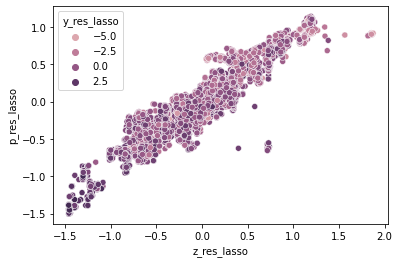

In [13]:
sns.scatterplot(hue=testdf['y_res_lasso'],y=testdf['p_res_lasso'], x=testdf['z_res_lasso'])

In [14]:
np.corrcoef(z_res_lasso,p_res_lasso)  # correlation between p and z -> if too low or high it might be a weak instrument

array([[1.        , 0.93725622],
       [0.93725622, 1.        ]])

Using RForest 1st stage 

In [15]:
# fit first stage models
rfor_l=RandomForestRegressor(max_features=0.65, n_estimators=500).fit(x_lasso_train, y_lasso_train)
rfor_m=RandomForestRegressor(max_features=0.65, n_estimators=500).fit(x_lasso_train, z_lasso_train)
rfor_r=RandomForestRegressor(max_features=0.65, n_estimators=500).fit(x_lasso_train, p_lasso_train)

In [16]:
# DML MODEL:

#create data object
obj_dml_data = dml.DoubleMLData(dmlset_lasso_train, 'L_PRODUCT_ORDER_AMT', 'L_AVG_SELL_PRICE', z_cols='L_AVG_PURCHASE_PRICE')
#run DML model
dml_pliv_obj = dml.DoubleMLPLIV(obj_dml_data, rfor_l, rfor_m, rfor_r)
#print output
print(dml_pliv_obj.fit().bootstrap())

================== DoubleMLPLIV Object ==================

------------------ Data summary      ------------------
Outcome variable: L_PRODUCT_ORDER_AMT
Treatment variable(s): ['L_AVG_SELL_PRICE']
Covariates: ['CONST', 'ARTICLE_TIER_BETTER', 'ARTICLE_TIER_GOOD', 'ART_BRAND_TIER_PRICE_ENTRY', 'ART_BRAND_TIER_PRIVATE_LABEL', 'PACKAGING_BOX', 'PACKAGING_CAN', 'PACKAGING_PACK', 'ARTICLE_CAT_2_DRINKPAKJES', 'ARTICLE_CAT_2_FRUITDRANK', 'ARTICLE_CAT_2_IJSTHEE', 'ARTICLE_CAT_2_LIMONADE_SIROPEN', 'ARTICLE_CAT_2_SAPPEN_SMOOTHIES', 'ARTICLE_CAT_2_SINAS_LEMON_CASSIS', 'ARTICLE_CAT_2_SPECIAAL_FRIS', 'ARTICLE_CAT_2_SPORT_ENERGYDRINK', 'ARTICLE_CAT_2_WATER', 'PROMO_DUMMY', 'PPL2', 'PPL3', 'POSTPPL1', 'POSTPPL2', 'POSTPPL3', 'L_AVG_HIGH_TEMP', 'L_NR_ARTICLES_IN_CAT', 'L_NR_ARTICLES_IN_CAT_2', 'AVG_UNAVAILABILITY_PERC', 'ART_CONTENT_VOLUME', 'ART_IS_MULTIPACK', 'HOLIDAY', 'WEEK_NR']
Instrument variable(s): ['L_AVG_PURCHASE_PRICE']
No. Observations: 50933

------------------ Score & algorithm ----------

First stage analysis

In [17]:
# do predictions and residualize variables in order to do analysis/judgement of first stage
# 
y_pred_L=rfor_l.predict(x_lasso_test)
p_pred_R=rfor_r.predict(x_lasso_test)
z_pred_M=rfor_m.predict(x_lasso_test)
#get residualized vars
y_res_rfor=y_lasso_test-y_pred_L
p_res_rfor=p_lasso_test-p_pred_R
z_res_rfor=z_lasso_test-z_pred_M
#get dataframe of test set only
# testdf=df_log.iloc[p_res_lasso.reset_index()['index'],:] # created this already after lasso estimation
# add residualized variables to test set such that you can compare them to columns to see potential correlations
testdf['y_res_rfor'] =y_res_rfor
testdf['p_res_rfor']=p_res_rfor
testdf['z_res_rfor']=z_res_rfor
#get rmse of predictions
print(mean_squared_error(y_lasso_test, y_pred_L,squared=True))
print(mean_squared_error(p_lasso_test, p_pred_R,squared=True))
print(mean_squared_error(z_lasso_test, z_pred_M,squared=True))

1.062523608750319
0.009386768220327857
0.007326837432656025


C:\Users\Florence Piet\AppData\Local\Temp\ipykernel_14600\1671781141.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdf['y_res_rfor'] =y_res_rfor
C:\Users\Florence Piet\AppData\Local\Temp\ipykernel_14600\1671781141.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdf['p_res_rfor']=p_res_rfor
C:\Users\Florence Piet\AppData\Local\Temp\ipykernel_14600\1671781141.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

Optional: visual analysis of residualized variables:

<AxesSubplot:xlabel='WEEK_NR', ylabel='p_res_rfor'>

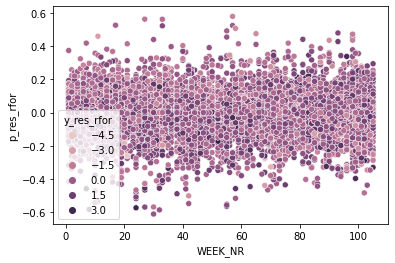

In [18]:
sns.scatterplot(y=testdf['p_res_rfor'],x=testdf['WEEK_NR'], hue=testdf['y_res_rfor'])

<AxesSubplot:xlabel='z_res_rfor', ylabel='p_res_rfor'>

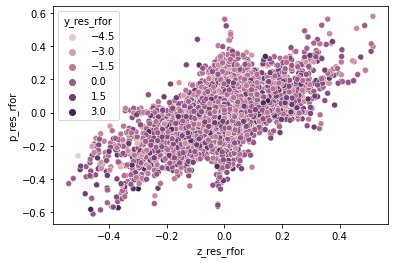

In [19]:
sns.scatterplot(y=testdf['p_res_rfor'],x=testdf['z_res_rfor'], hue=testdf['y_res_rfor'])

In [20]:
np.corrcoef(z_res_rfor,p_res_rfor) # correlation between p and z -> if too low or high it is a weak instrument

array([[1.        , 0.59214623],
       [0.59214623, 1.        ]])

Using XGB first stage 

First replace -inf with nan, as xgboost can handle nan values (but no -inf)

In [21]:
#xgboost can handle np.nan (instead of -inf): - this is for the lagged demand variable which has value of -infinity in case of zero demand (after log transformation of data)
df_log.replace([-np.inf], np.nan, inplace=True)
df_log.replace([-np.inf], np.nan, inplace=True)

In [22]:
# XGBoost new data partition, because of different imputed value for lagged demand
x= df_log[['CONST','ARTICLE_TIER_BETTER', 'ARTICLE_TIER_GOOD',
       'ART_BRAND_TIER_PRICE_ENTRY', 'ART_BRAND_TIER_PRIVATE_LABEL',
       'PACKAGING_BOX', 'PACKAGING_CAN', 'PACKAGING_PACK',
       'ARTICLE_CAT_2_DRINKPAKJES', 'ARTICLE_CAT_2_FRUITDRANK',
       'ARTICLE_CAT_2_IJSTHEE', 'ARTICLE_CAT_2_LIMONADE_SIROPEN',
       'ARTICLE_CAT_2_SAPPEN_SMOOTHIES', 'ARTICLE_CAT_2_SINAS_LEMON_CASSIS',
       'ARTICLE_CAT_2_SPECIAAL_FRIS', 'ARTICLE_CAT_2_SPORT_ENERGYDRINK',
       'ARTICLE_CAT_2_WATER', 'PROMO_DUMMY', 'PPL2','PPL3', 'POSTPPL1', 'POSTPPL2',
       'POSTPPL3', 'L_AVG_HIGH_TEMP'#,'L_TOTAL_ORDER_AMT'
       ,'L_NR_ARTICLES_IN_CAT', 
       'L_NR_ARTICLES_IN_CAT_2',# 'L_WEEK_NR',
       'AVG_UNAVAILABILITY_PERC',
       'ART_CONTENT_VOLUME', 'ART_IS_MULTIPACK', 
       # 'L_PRODUCT_ORDER_AMT_T_2_m','L_PRODUCT_ORDER_AMT_T_1_m' 
       # 'L_PRODUCT_ORDER_AMT_T_1', 'L_PRODUCT_ORDER_AMT_T_2',
       'HOLIDAY','WEEK_NR'
       ]]
y = df_log['L_PRODUCT_ORDER_AMT']
p = df_log['L_AVG_SELL_PRICE']
z = df_log['L_AVG_PURCHASE_PRICE']

dmlset=x.join(y.to_frame().join(p.to_frame().join(z.to_frame()))) #needed in dml algortihm

In [23]:
x_train, x_test, y_train, y_test, p_train, p_test, z_train, z_test, dmlset_train, dmlset_test = train_test_split(x,y,p,z,dmlset,random_state=44) #in case want to see how first stages perform

Optional: default XGB

In [39]:
# fit first stages 
xgbr_l=xgb.XGBRegressor().fit(x_train,y_train)
xgbr_m=xgb.XGBRegressor().fit(x_train,z_train)
xgbr_r=xgb.XGBRegressor().fit(x_train,p_train)
# create data object
obj_dml_data = dml.DoubleMLData(dmlset, 'L_PRODUCT_ORDER_AMT', 'L_AVG_SELL_PRICE', z_cols='L_AVG_PURCHASE_PRICE',force_all_x_finite='allow-nan')
# run model
dml_pliv_obj = dml.DoubleMLPLIV(obj_dml_data, xgbr_l, xgbr_m, xgbr_r, )
#print output
print(dml_pliv_obj.fit().bootstrap())

================== DoubleMLPLIV Object ==================

------------------ Data summary      ------------------
Outcome variable: L_PRODUCT_ORDER_AMT
Treatment variable(s): ['L_AVG_SELL_PRICE']
Covariates: ['CONST', 'ARTICLE_TIER_BETTER', 'ARTICLE_TIER_GOOD', 'ART_BRAND_TIER_PRICE_ENTRY', 'ART_BRAND_TIER_PRIVATE_LABEL', 'PACKAGING_BOX', 'PACKAGING_CAN', 'PACKAGING_PACK', 'ARTICLE_CAT_2_DRINKPAKJES', 'ARTICLE_CAT_2_FRUITDRANK', 'ARTICLE_CAT_2_IJSTHEE', 'ARTICLE_CAT_2_LIMONADE_SIROPEN', 'ARTICLE_CAT_2_SAPPEN_SMOOTHIES', 'ARTICLE_CAT_2_SINAS_LEMON_CASSIS', 'ARTICLE_CAT_2_SPECIAAL_FRIS', 'ARTICLE_CAT_2_SPORT_ENERGYDRINK', 'ARTICLE_CAT_2_WATER', 'PROMO_DUMMY', 'PPL2', 'PPL3', 'POSTPPL1', 'POSTPPL2', 'POSTPPL3', 'L_AVG_HIGH_TEMP', 'L_NR_ARTICLES_IN_CAT', 'L_NR_ARTICLES_IN_CAT_2', 'AVG_UNAVAILABILITY_PERC', 'ART_CONTENT_VOLUME', 'ART_IS_MULTIPACK', 'HOLIDAY', 'WEEK_NR']
Instrument variable(s): ['L_AVG_PURCHASE_PRICE']
No. Observations: 67911

------------------ Score & algorithm ----------

DML Model: XGB

In [24]:
# fit first stages 
xgbr_l=xgb.XGBRegressor(colsample_bytree= 1, gamma= 0, learning_rate= 0.2, max_depth= None, n_estimators= 500).fit(x_train,y_train)
xgbr_m=xgb.XGBRegressor(colsample_bytree= 1, gamma= 0, learning_rate= 0.2, max_depth= None, n_estimators= 500).fit(x_train,z_train)
xgbr_r=xgb.XGBRegressor(colsample_bytree= 1, gamma= 0, learning_rate= 0.2, max_depth= None, n_estimators= 500).fit(x_train,p_train)
# create data object
obj_dml_data = dml.DoubleMLData(dmlset_train, 'L_PRODUCT_ORDER_AMT', 'L_AVG_SELL_PRICE', z_cols='L_AVG_PURCHASE_PRICE',force_all_x_finite='allow-nan')
# run model
dml_pliv_obj = dml.DoubleMLPLIV(obj_dml_data, xgbr_l, xgbr_m, xgbr_r, )
#print output
print(dml_pliv_obj.fit().bootstrap())

================== DoubleMLPLIV Object ==================

------------------ Data summary      ------------------
Outcome variable: L_PRODUCT_ORDER_AMT
Treatment variable(s): ['L_AVG_SELL_PRICE']
Covariates: ['CONST', 'ARTICLE_TIER_BETTER', 'ARTICLE_TIER_GOOD', 'ART_BRAND_TIER_PRICE_ENTRY', 'ART_BRAND_TIER_PRIVATE_LABEL', 'PACKAGING_BOX', 'PACKAGING_CAN', 'PACKAGING_PACK', 'ARTICLE_CAT_2_DRINKPAKJES', 'ARTICLE_CAT_2_FRUITDRANK', 'ARTICLE_CAT_2_IJSTHEE', 'ARTICLE_CAT_2_LIMONADE_SIROPEN', 'ARTICLE_CAT_2_SAPPEN_SMOOTHIES', 'ARTICLE_CAT_2_SINAS_LEMON_CASSIS', 'ARTICLE_CAT_2_SPECIAAL_FRIS', 'ARTICLE_CAT_2_SPORT_ENERGYDRINK', 'ARTICLE_CAT_2_WATER', 'PROMO_DUMMY', 'PPL2', 'PPL3', 'POSTPPL1', 'POSTPPL2', 'POSTPPL3', 'L_AVG_HIGH_TEMP', 'L_NR_ARTICLES_IN_CAT', 'L_NR_ARTICLES_IN_CAT_2', 'AVG_UNAVAILABILITY_PERC', 'ART_CONTENT_VOLUME', 'ART_IS_MULTIPACK', 'HOLIDAY', 'WEEK_NR']
Instrument variable(s): ['L_AVG_PURCHASE_PRICE']
No. Observations: 50933

------------------ Score & algorithm ----------

Optional: XGBoost first stage model evaluation:

In [40]:


#get residualized vars for test set
y_res=y_test-xgbr_l.predict(x_test)
p_res=p_test-xgbr_r.predict(x_test)
z_res=z_test-xgbr_m.predict(x_test)
# add them to test set in order to compare with other variables from dataset
testdf['y_res'] =y_res
testdf['p_res']=p_res
testdf['z_res']=z_res
#print rmse of first stage prediction
print(mean_squared_error(y_lasso_test, xgbr_l.predict(x_test),squared=True))
print(mean_squared_error(p_lasso_test, xgbr_r.predict(x_test),squared=True))
print(mean_squared_error(z_lasso_test, xgbr_m.predict(x_test),squared=True))

0.9117800909974925
0.012430437796611387
0.01154205112578936


C:\Users\Florence Piet\AppData\Local\Temp\ipykernel_14600\1780554469.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdf['y_res'] =y_res
C:\Users\Florence Piet\AppData\Local\Temp\ipykernel_14600\1780554469.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdf['p_res']=p_res
C:\Users\Florence Piet\AppData\Local\Temp\ipykernel_14600\1780554469.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

First stage evaluation

<AxesSubplot:xlabel='WEEK_NR', ylabel='p_res'>

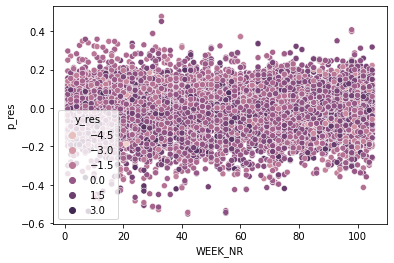

In [26]:
sns.scatterplot(y=testdf['p_res'],x=testdf['WEEK_NR'], hue=testdf['y_res'])

<AxesSubplot:xlabel='z_res', ylabel='p_res'>

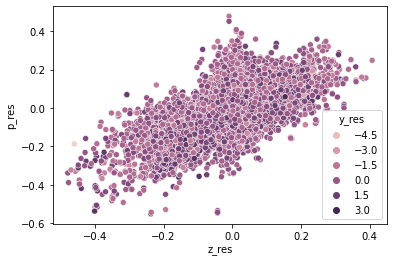

In [27]:
sns.scatterplot(y=testdf['p_res'],x=testdf['z_res'], hue=testdf['y_res'])

In [28]:
np.corrcoef(z_res,p_res) # correlation between p and z -> if too low or high it is a weak instrument

array([[1.       , 0.6020556],
       [0.6020556, 1.       ]])

In [29]:
np.corrcoef(z,p) # correlation before transforming/residualizing (baseline)

array([[1.        , 0.94535257],
       [0.94535257, 1.        ]])

Comparing the Lasso and XGB first stages for residualizing Z and P --> to see with which first stage transforms the correlation between P and Z the most/least

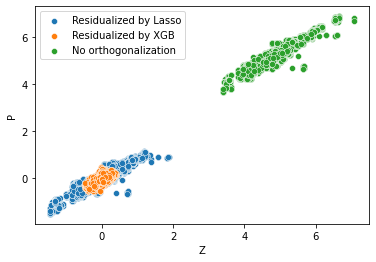

In [30]:
sns.scatterplot(y=p_res_lasso,x=z_res_lasso)
sns.scatterplot(y=p_res,x=z_res)
sns.scatterplot(y=p_test,x=z_test)
plt.xlabel('Z')
plt.ylabel('P')
plt.legend(labels=['Residualized by Lasso', 'Residualized by XGB', 'No orthogonalization'])

# Predictions (to do residual analysis)

In [41]:
#make first stage estimated values trained on 2020-2022 set for both lasso and xgb
# for demand: estimate first stage l(X)
y_pred_lasso=lasso_l.predict(x_lasso_test) # models fitted on train set
y_pred_rfor=rfor_l.predict(x_lasso_test)
y_pred_xgb=xgbr_l.predict(x_test)

# do the same on training data:
# for demand l(X)
y_pred_lasso_train=lasso_l.predict(x_lasso_train) # models fitted on train set
y_pred_rfor_train=rfor_l.predict(x_lasso_train)
y_pred_xgb_train=xgbr_l.predict(x_train)

#make final predictions based on estimated theta's and first stages
#use estimated theta's:
theta_lasso=-1.059115
theta_rfor=-0.605206
theta_xgb=-0.440833

#final estimated demand:
# note that first stage p is not needed directly here, it was used in estimating theta but is not necessary in making prediction for Y. see equation 4.1 thesis, which this prediction is based on.
#test data set (left out of estimtation)
final_y_pred_lasso=(p_lasso_test)*(theta_lasso)+y_pred_lasso
final_y_pred_rfor=(p_lasso_test)*(theta_rfor)+y_pred_rfor
final_y_pred_xgb=(p_test)*(theta_xgb)+y_pred_xgb

#train data set
final_y_pred_lasso_train=(p_lasso_train)*(theta_lasso)+y_pred_lasso_train
final_y_pred_rfor_train=(p_lasso_train)*(theta_rfor)+y_pred_rfor_train
final_y_pred_xgb_train=(p_train)*(theta_xgb)+y_pred_xgb_train

#RMSE of models:
# test set
lassormse=mean_squared_error(final_y_pred_lasso,y_lasso_test,squared=True)
rforrmse=mean_squared_error(final_y_pred_rfor,y_lasso_test,squared=True)
xgbrmse=mean_squared_error(final_y_pred_xgb, y_test,squared=True)
print("Lasso RMSE on test dataset using estimated theta = ", lassormse)
print("Rfor RMSE on test dataset using estimated theta = ", rforrmse)
print("XGB RMSE on test dataset using estimated theta = ", xgbrmse)

#train set
lassormsetr=mean_squared_error(final_y_pred_lasso_train,y_lasso_train,squared=True)
rforrmsetr=mean_squared_error(final_y_pred_rfor_train,y_lasso_train,squared=True)
xgbrmsetr=mean_squared_error(final_y_pred_xgb_train, y_train,squared=True)
print("\nLasso RMSE on train dataset using estimated theta = ", lassormsetr)
print("Rfor RMSE on train dataset using estimated theta = ", rforrmsetr)
print("XGB RMSE on train dataset using estimated theta = ", xgbrmsetr)

Lasso RMSE on test dataset using estimated theta =  32.059098396887094
Rfor RMSE on test dataset using estimated theta =  11.123120188826597
XGB RMSE on test dataset using estimated theta =  6.233733011492262

Lasso RMSE on train dataset using estimated theta =  32.08490533214303
Rfor RMSE on train dataset using estimated theta =  10.325597188000183
XGB RMSE on train dataset using estimated theta =  6.12107948417052


Plot Residuals Train set:

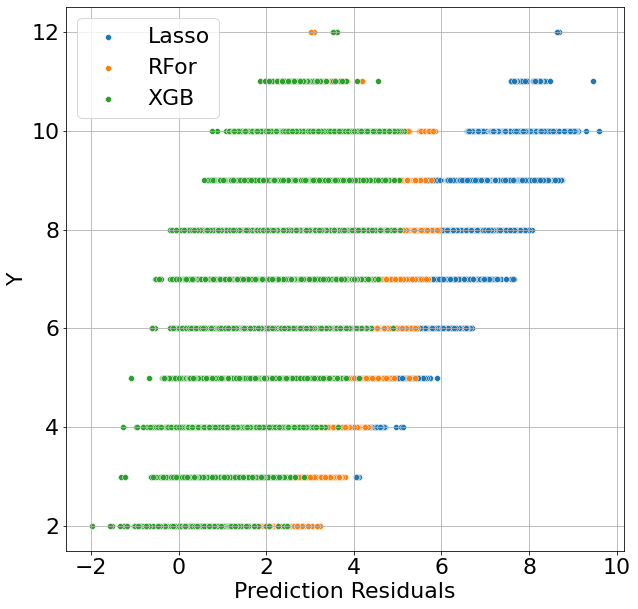

In [42]:
plt.rcParams.update({'font.size': 22})

plt.figure(figsize=(10,10))
sns.scatterplot(y=y_lasso_train,x=y_lasso_train-final_y_pred_lasso_train,label='Lasso') # using the final predictions we just did
sns.scatterplot(y=y_lasso_train,x=y_lasso_train-final_y_pred_rfor_train,label='RFor')
sns.scatterplot(y=y_lasso_train,x=y_lasso_train-final_y_pred_xgb_train,label='XGB')
plt.xlabel('Prediction Residuals')
plt.ylabel('Y')
plt.grid()
#labels=[ 'Lasso','RFor','XGB']
plt.legend()

Correlation of prediction residuals and observations:

In [43]:
pd.DataFrame({'Y': y_lasso_train, 'Y_pred Lasso': final_y_pred_lasso_train, 'Y_pred RFor': final_y_pred_rfor_train, 'Y_pred XGB': final_y_pred_xgb_train}).corr()

,Y,Y_pred Lasso,Y_pred RFor,Y_pred XGB
Y,1.000000,0.447134,0.906995,0.745579
Y_pred Lasso,0.447134,1.000000,0.650271,0.706575
Y_pred RFor,0.906995,0.650271,1.000000,0.904807
Y_pred XGB,0.745579,0.706575,0.904807,1.000000


In [44]:
pd.DataFrame({'Y': y_lasso_train, 'Y_res Lasso': y_lasso_train-final_y_pred_lasso_train, 
'Y_res RFor': y_lasso_train-final_y_pred_rfor_train, 'Y_res XGB': y_lasso_train-final_y_pred_xgb_train}).corr()

,Y,Y_res Lasso,Y_res RFor,Y_res XGB
Y,1.000000,0.904525,0.353696,0.620942
Y_res Lasso,0.904525,1.000000,0.579046,0.770928
Y_res RFor,0.353696,0.579046,1.000000,0.816744
Y_res XGB,0.620942,0.770928,0.816744,1.000000


Residuals Test set:

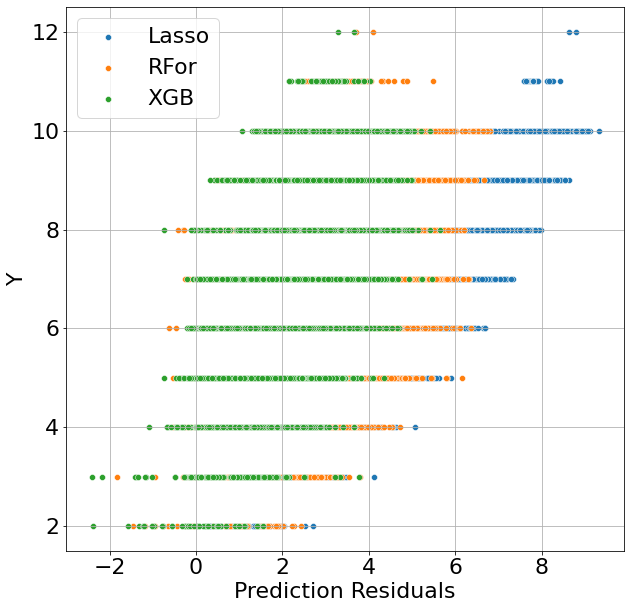

In [45]:
plt.rcParams.update({'font.size': 22})

plt.figure(figsize=(10,10))
sns.scatterplot(y=y_lasso_test,x=y_lasso_test-final_y_pred_lasso,label='Lasso')
sns.scatterplot(y=y_lasso_test,x=y_lasso_test-final_y_pred_rfor,label='RFor')
sns.scatterplot(y=y_lasso_test,x=y_lasso_test-final_y_pred_xgb,label='XGB')
plt.xlabel('Prediction Residuals')
plt.ylabel('Y')
plt.grid()
#labels=[ 'Lasso','RFor','XGB']
plt.legend()

Correlation of residuals and observations

In [46]:
pd.DataFrame({'Y': y_lasso_test, 'Y_pred Lasso': final_y_pred_lasso, 'Y_pred RFor': final_y_pred_rfor, 'Y_pred XGB': final_y_pred_xgb}).corr()

,Y,Y_pred Lasso,Y_pred RFor,Y_pred XGB
Y,1.000000,0.456040,0.664398,0.706881
Y_pred Lasso,0.456040,1.000000,0.689994,0.717696
Y_pred RFor,0.664398,0.689994,1.000000,0.927719
Y_pred XGB,0.706881,0.717696,0.927719,1.000000


In [47]:
pd.DataFrame({'Y': y_lasso_test, 'Y_res Lasso': y_lasso_test-final_y_pred_lasso, 
'Y_res RFor': y_lasso_test-final_y_pred_rfor, 'Y_res XGB': y_lasso_test-final_y_pred_xgb}).corr()

,Y,Y_res Lasso,Y_res RFor,Y_res XGB
Y,1.000000,0.902617,0.517342,0.623064
Y_res Lasso,0.902617,1.000000,0.681291,0.773827
Y_res RFor,0.517342,0.681291,1.000000,0.902338
Y_res XGB,0.623064,0.773827,0.902338,1.000000


# Model Variation: Simpler model for Price and Instrument than for demand:

Variation two: linear regression instead of lasso (just simple low-dim)

In [48]:
from sklearn.linear_model import LinearRegression
# fit first stages 
xgbr_l=xgb.XGBRegressor(colsample_bytree= 1, gamma= 0, learning_rate= 0.2, max_depth= None, n_estimators= 500).fit(x_train,y_train)
reg_m = LinearRegression().fit(x_train, z_train)
reg_r = LinearRegression().fit(x_train, p_train)
# create data object
obj_dml_data = dml.DoubleMLData(dmlset_train, 'L_PRODUCT_ORDER_AMT', 'L_AVG_SELL_PRICE', z_cols='L_AVG_PURCHASE_PRICE',force_all_x_finite='allow-nan')
# run model
dml_pliv_obj = dml.DoubleMLPLIV(obj_dml_data, xgbr_l, reg_m, reg_r, )
#print output
print(dml_pliv_obj.fit().bootstrap())

================== DoubleMLPLIV Object ==================

------------------ Data summary      ------------------
Outcome variable: L_PRODUCT_ORDER_AMT
Treatment variable(s): ['L_AVG_SELL_PRICE']
Covariates: ['CONST', 'ARTICLE_TIER_BETTER', 'ARTICLE_TIER_GOOD', 'ART_BRAND_TIER_PRICE_ENTRY', 'ART_BRAND_TIER_PRIVATE_LABEL', 'PACKAGING_BOX', 'PACKAGING_CAN', 'PACKAGING_PACK', 'ARTICLE_CAT_2_DRINKPAKJES', 'ARTICLE_CAT_2_FRUITDRANK', 'ARTICLE_CAT_2_IJSTHEE', 'ARTICLE_CAT_2_LIMONADE_SIROPEN', 'ARTICLE_CAT_2_SAPPEN_SMOOTHIES', 'ARTICLE_CAT_2_SINAS_LEMON_CASSIS', 'ARTICLE_CAT_2_SPECIAAL_FRIS', 'ARTICLE_CAT_2_SPORT_ENERGYDRINK', 'ARTICLE_CAT_2_WATER', 'PROMO_DUMMY', 'PPL2', 'PPL3', 'POSTPPL1', 'POSTPPL2', 'POSTPPL3', 'L_AVG_HIGH_TEMP', 'L_NR_ARTICLES_IN_CAT', 'L_NR_ARTICLES_IN_CAT_2', 'AVG_UNAVAILABILITY_PERC', 'ART_CONTENT_VOLUME', 'ART_IS_MULTIPACK', 'HOLIDAY', 'WEEK_NR']
Instrument variable(s): ['L_AVG_PURCHASE_PRICE']
No. Observations: 50933

------------------ Score & algorithm ----------

In [49]:
from sklearn.linear_model import LinearRegression
# fit first stages 
# xgbr_l=xgb.XGBRegressor(colsample_bytree= 1, gamma= 0, learning_rate= 0.2, max_depth= None, n_estimators= 500).fit(x_train,y_train)
# reg_m = LinearRegression().fit(x_train, z_train)
# reg_r = LinearRegression().fit(x_train, p_train)
# create data object
obj_dml_data = dml.DoubleMLData(dmlset_train, 'L_PRODUCT_ORDER_AMT', 'L_AVG_SELL_PRICE', z_cols='L_AVG_PURCHASE_PRICE',force_all_x_finite='allow-nan')
# run model
dml_pliv_obj = dml.DoubleMLPLIV(obj_dml_data, rfor_l, reg_m, reg_r, )
#print output
print(dml_pliv_obj.fit().bootstrap())

================== DoubleMLPLIV Object ==================

------------------ Data summary      ------------------
Outcome variable: L_PRODUCT_ORDER_AMT
Treatment variable(s): ['L_AVG_SELL_PRICE']
Covariates: ['CONST', 'ARTICLE_TIER_BETTER', 'ARTICLE_TIER_GOOD', 'ART_BRAND_TIER_PRICE_ENTRY', 'ART_BRAND_TIER_PRIVATE_LABEL', 'PACKAGING_BOX', 'PACKAGING_CAN', 'PACKAGING_PACK', 'ARTICLE_CAT_2_DRINKPAKJES', 'ARTICLE_CAT_2_FRUITDRANK', 'ARTICLE_CAT_2_IJSTHEE', 'ARTICLE_CAT_2_LIMONADE_SIROPEN', 'ARTICLE_CAT_2_SAPPEN_SMOOTHIES', 'ARTICLE_CAT_2_SINAS_LEMON_CASSIS', 'ARTICLE_CAT_2_SPECIAAL_FRIS', 'ARTICLE_CAT_2_SPORT_ENERGYDRINK', 'ARTICLE_CAT_2_WATER', 'PROMO_DUMMY', 'PPL2', 'PPL3', 'POSTPPL1', 'POSTPPL2', 'POSTPPL3', 'L_AVG_HIGH_TEMP', 'L_NR_ARTICLES_IN_CAT', 'L_NR_ARTICLES_IN_CAT_2', 'AVG_UNAVAILABILITY_PERC', 'ART_CONTENT_VOLUME', 'ART_IS_MULTIPACK', 'HOLIDAY', 'WEEK_NR']
Instrument variable(s): ['L_AVG_PURCHASE_PRICE']
No. Observations: 50933

------------------ Score & algorithm ----------

In [50]:
#make first stage estimated values trained on 2020-2022 set for both lasso and xgb
# for demand: estimate first stage l(X)
y_pred_rfor=rfor_l.predict(x_lasso_test)
y_pred_xgb=xgbr_l.predict(x_test)

# do the same on training data:
# for demand l(X)
y_pred_rfor_train=rfor_l.predict(x_lasso_train)
y_pred_xgb_train=xgbr_l.predict(x_train)

#make final predictions based on estimated theta's and first stages
#use estimated theta's:
theta_rfor2=-0.128078
theta_xgb2=-0.120857
theta_rfor=-0.605206
theta_xgb=-0.440833

#final estimated demand:
# note that first stage p is not needed directly here, it was used in estimating theta but is not necessary in making prediction for Y. see equation 4.1 thesis, which this prediction is based on.
#test data set (left out of estimtation)
final_y_pred_rfor2=(p_lasso_test)*(theta_rfor2)+y_pred_rfor
final_y_pred_xgb2=(p_test)*(theta_xgb2)+y_pred_xgb
final_y_pred_rfor=(p_lasso_test)*(theta_rfor)+y_pred_rfor
final_y_pred_xgb=(p_test)*(theta_xgb)+y_pred_xgb


#train data set
final_y_pred_rfor_train2=(p_lasso_train)*(theta_rfor2)+y_pred_rfor_train
final_y_pred_xgb_train2=(p_train)*(theta_xgb2)+y_pred_xgb_train
final_y_pred_rfor_train=(p_lasso_train)*(theta_rfor)+y_pred_rfor_train
final_y_pred_xgb_train=(p_train)*(theta_xgb)+y_pred_xgb_train

#RMSE of models:
# test set
rforrmse=mean_squared_error(final_y_pred_rfor,y_lasso_test,squared=True)
xgbrmse=mean_squared_error(final_y_pred_xgb, y_test,squared=True)
print("Rfor2 RMSE on test dataset using estimated theta = ", rforrmse)
print("XGB2 RMSE on test dataset using estimated theta = ", xgbrmse)

#train set
rforrmsetr=mean_squared_error(final_y_pred_rfor_train,y_lasso_train,squared=True)
xgbrmsetr=mean_squared_error(final_y_pred_xgb_train, y_train,squared=True)
print("Rfor2 RMSE on train dataset using estimated theta = ", rforrmsetr)
print("XGB2 RMSE on train dataset using estimated theta = ", xgbrmsetr)

Rfor2 RMSE on test dataset using estimated theta =  11.123120188826597
XGB2 RMSE on test dataset using estimated theta =  6.238051864379323
Rfor2 RMSE on train dataset using estimated theta =  10.325597188000183
XGB2 RMSE on train dataset using estimated theta =  5.948071387984381


Plot Residuals Train set:

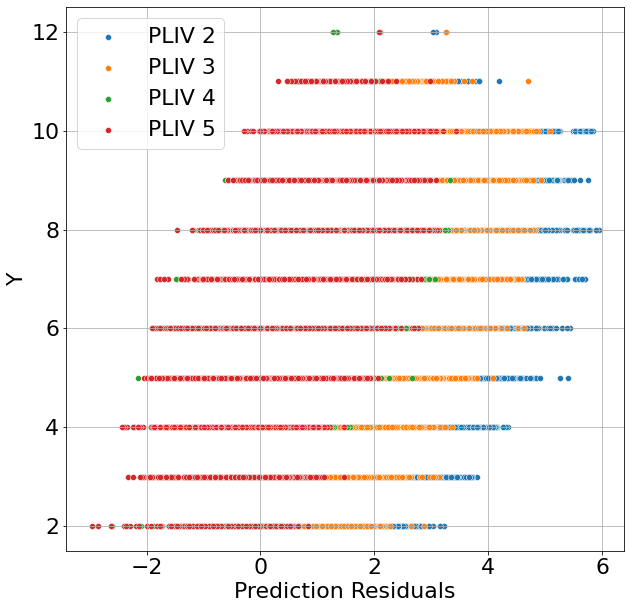

In [51]:
plt.rcParams.update({'font.size': 22})

plt.figure(figsize=(10,10))
sns.scatterplot(y=y_lasso_train,x=y_lasso_train-final_y_pred_rfor_train,label='PLIV 2')
sns.scatterplot(y=y_lasso_train,x=y_lasso_train-final_y_pred_xgb_train,label='PLIV 3')
sns.scatterplot(y=y_lasso_train,x=y_lasso_train-final_y_pred_rfor_train2,label='PLIV 4')
sns.scatterplot(y=y_lasso_train,x=y_lasso_train-final_y_pred_xgb_train2,label='PLIV 5')
plt.xlabel('Prediction Residuals')
plt.ylabel('Y')
plt.grid()
#labels=[ 'Lasso','RFor','XGB']
plt.legend()

Correlation of prediction residuals and observations:

In [52]:
pd.DataFrame({'Y': y_lasso_train, #'Y_pred Lasso': final_y_pred_lasso_train, 
              'Y_pred RFor': final_y_pred_rfor_train, 'Y_pred XGB': final_y_pred_xgb_train}).corr()

,Y,Y_pred RFor,Y_pred XGB
Y,1.000000,0.906995,0.805769
Y_pred RFor,0.906995,1.000000,0.941723
Y_pred XGB,0.805769,0.941723,1.000000


In [53]:
pd.DataFrame({'Y': y_lasso_train, #'Y_res Lasso': y_lasso_train-final_y_pred_lasso_train, 
'Y_res RFor2': y_lasso_train-final_y_pred_rfor_train2, 'Y_res XGB2': y_lasso_train-final_y_pred_xgb_train2,
'Y_res RFor': y_lasso_train-final_y_pred_rfor_train, 'Y_res XGB': y_lasso_train-final_y_pred_xgb_train}).corr()

,Y,Y_res RFor2,Y_res XGB2,Y_res RFor,Y_res XGB
Y,1.000000,0.545497,0.640119,0.353696,0.562938
Y_res RFor2,0.545497,1.000000,0.868156,0.914169,0.862685
Y_res XGB2,0.640119,0.868156,1.000000,0.778848,0.980910
Y_res RFor,0.353696,0.914169,0.778848,1.000000,0.852794
Y_res XGB,0.562938,0.862685,0.980910,0.852794,1.000000


Residuals Test set:

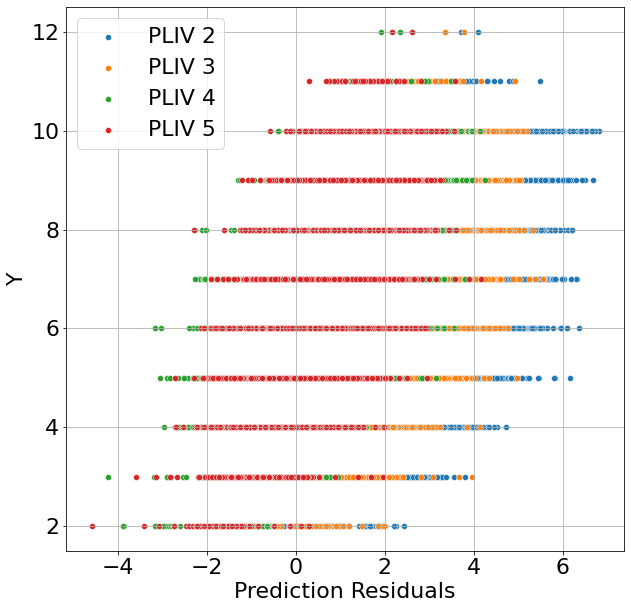

In [54]:
plt.rcParams.update({'font.size': 22})

plt.figure(figsize=(10,10))

sns.scatterplot(y=y_lasso_test,x=y_lasso_test-final_y_pred_rfor,label='PLIV 2')
sns.scatterplot(y=y_lasso_test,x=y_lasso_test-final_y_pred_xgb,label='PLIV 3')
sns.scatterplot(y=y_lasso_test,x=y_lasso_test-final_y_pred_rfor2,label='PLIV 4')
sns.scatterplot(y=y_lasso_test,x=y_lasso_test-final_y_pred_xgb2,label='PLIV 5')

plt.xlabel('Prediction Residuals')
plt.ylabel('Y')
plt.grid()
#labels=[ 'Lasso','RFor','XGB']
plt.legend()

Correlation of residuals and observations

In [55]:
pd.DataFrame({'Y': y_lasso_test, #'Y_pred Lasso': final_y_pred_lasso,
               'Y_pred RFor': final_y_pred_rfor, 'Y_pred XGB': final_y_pred_xgb}).corr()

,Y,Y_pred RFor,Y_pred XGB
Y,1.000000,0.664398,0.711971
Y_pred RFor,0.664398,1.000000,0.936985
Y_pred XGB,0.711971,0.936985,1.000000


In [56]:
pd.DataFrame({'Y': y_lasso_test,# 'Y_res Lasso': y_lasso_test-final_y_pred_lasso, 
'Y_res RFor2': y_lasso_test-final_y_pred_rfor2, 'Y_res XGB2': y_lasso_test-final_y_pred_xgb2,
'Y_res RFor': y_lasso_test-final_y_pred_rfor, 'Y_res XGB': y_lasso_test-final_y_pred_xgb}).corr()

,Y,Y_res RFor2,Y_res XGB2,Y_res RFor,Y_res XGB
Y,1.000000,0.606934,0.647437,0.517342,0.584111
Y_res RFor2,0.606934,1.000000,0.913679,0.974585,0.902627
Y_res XGB2,0.647437,0.913679,1.000000,0.889953,0.986221
Y_res RFor,0.517342,0.974585,0.889953,1.000000,0.916243
Y_res XGB,0.584111,0.902627,0.986221,0.916243,1.000000


Prediction errors

In [57]:
reg_m = LinearRegression().fit(x_train, z_train)
reg_r = LinearRegression().fit(x_train, p_train)
z_pred=reg_m.predict(x_test)
p_pred=reg_r.predict(x_test)
print(mean_squared_error(z_pred,z_test,squared=True),
mean_squared_error(p_pred,p_test,squared=True))

0.04073317209514668 0.03758441521431344


# Extra residual analysis : Predict on 2023 data

In [58]:
# load dataset
df_test2023=pd.read_csv("dataframe_transformed_2023.csv")

In [59]:
listofHolidays=["2020-12-28",
                "2021-01-04",
                "2021-03-29",
                "2021-05-03",
                "2021-07-26",
                "2021-08-02",
                "2021-08-09",
                "2021-08-16",
                "2021-12-27",
                "2022-01-03",
                "2022-04-11",
                "2022-05-02",
                "2022-07-25",
                "2022-08-01",
                "2022-08-08",
                "2022-08-15",
                "2022-12-26"
                ]
df_test2023['HOLIDAY']=(df_test2023['WEEK_START_DATE'].isin(listofHolidays))*1

df_test2023=statsmodels.tools.tools.add_constant(df_test2023) # add a constant

In [60]:
df_test2023[['PPL2','PPL3', 'POSTPPL1']]=0 #these columns were nonexisted in the 2023 data but are needed to compare to data of before

In [61]:
# align column names to compare and use the same exact methods on 2023 set and original set
# normally when using the same query for the train and test set this is not an issue
# due to memoryError in DataTransformation script -> this issue occured -> query for two sets changed -> therefore need to realign


renamedict={'const':'CONST',
'l_AVG_HIGH_TEMP':'L_AVG_HIGH_TEMP',
'l_NR_ARTICLES_IN_CAT':'L_NR_ARTICLES_IN_CAT', 
'l_NR_ARTICLES_IN_CAT_2':'L_NR_ARTICLES_IN_CAT_2',
# 'l_product order amt_t-1_m':'L_PRODUCT_ORDER_AMT_T_1_m',
# 'l_product order amt_t-2_m':'L_PRODUCT_ORDER_AMT_T_2_m',
'l_AVG unavailability_perc':'AVG_UNAVAILABILITY_PERC',
'PPL_postPPL2':'POSTPPL2',
'PPL_postPPL3':'POSTPPL3',
'ARTICLE_TIER_Better':'ARTICLE_TIER_BETTER',
'ARTICLE_TIER_Good':'ARTICLE_TIER_GOOD',
'ART_BRAND_TIER_Price entry':'ART_BRAND_TIER_PRICE_ENTRY',
'ART_BRAND_TIER_Private label':'ART_BRAND_TIER_PRIVATE_LABEL',
'Packaging_Box':'PACKAGING_BOX',
'Packaging_Can':'PACKAGING_CAN', 
'Packaging_Pack':'PACKAGING_PACK',
'ARTICLE_CAT_2_Drinkpakjes':'ARTICLE_CAT_2_DRINKPAKJES',
'ARTICLE_CAT_2_Fruitdrank':'ARTICLE_CAT_2_FRUITDRANK',
'ARTICLE_CAT_2_IJsthee':'ARTICLE_CAT_2_IJSTHEE',
'ARTICLE_CAT_2_Limonade & siropen':'ARTICLE_CAT_2_LIMONADE_SIROPEN',
'ARTICLE_CAT_2_Sappen & smoothies':'ARTICLE_CAT_2_SAPPEN_SMOOTHIES',
'ARTICLE_CAT_2_Sinas, Lemon & Cassis':'ARTICLE_CAT_2_SINAS_LEMON_CASSIS',
'ARTICLE_CAT_2_Speciaal fris':'ARTICLE_CAT_2_SPECIAAL_FRIS',
'ARTICLE_CAT_2_Sport- & energydrink':'ARTICLE_CAT_2_SPORT_ENERGYDRINK',
'ARTICLE_CAT_2_Water':'ARTICLE_CAT_2_WATER',
'PROMO_DUMMY':'PROMO_DUMMY',
'WEEK_NR':'WEEK_NR', 
'ART_CONTENT_VOLUME':'ART_CONTENT_VOLUME', 
'ART_IS_MULTIPACK':'ART_IS_MULTIPACK',
'HOLIDAY':'HOLIDAY',
'l_product order amt': 'L_PRODUCT_ORDER_AMT',
'l_Avg sell price':'L_AVG_SELL_PRICE',
# 'l_product order amt_t-1':'L_PRODUCT_ORDER_AMT_T_1',
# 'l_product order amt_t-2':'L_PRODUCT_ORDER_AMT_T_2' 
}

In [62]:
#rename with dictionary defined above
df_test2023.rename(columns=renamedict,inplace=True)
# forgot to transform in query: replace zero unavailability (which got transformed to -infinity) with 0's
df_test2023['AVG_UNAVAILABILITY_PERC'].replace([-np.inf], np.nan, inplace=True)
df_test2023['AVG_UNAVAILABILITY_PERC'] = df_test2023['AVG_UNAVAILABILITY_PERC'].fillna(0)

In [63]:
# set up 2023 data subsets for modeling

x_2023_lasso= df_test2023[['CONST','ARTICLE_TIER_BETTER', 'ARTICLE_TIER_GOOD',
       'ART_BRAND_TIER_PRICE_ENTRY', 'ART_BRAND_TIER_PRIVATE_LABEL',
       'PACKAGING_BOX', 'PACKAGING_CAN', 'PACKAGING_PACK',
       'ARTICLE_CAT_2_DRINKPAKJES', 'ARTICLE_CAT_2_FRUITDRANK',
       'ARTICLE_CAT_2_IJSTHEE', 'ARTICLE_CAT_2_LIMONADE_SIROPEN',
       'ARTICLE_CAT_2_SAPPEN_SMOOTHIES', 'ARTICLE_CAT_2_SINAS_LEMON_CASSIS',
       'ARTICLE_CAT_2_SPECIAAL_FRIS', 'ARTICLE_CAT_2_SPORT_ENERGYDRINK',
       'ARTICLE_CAT_2_WATER', 
       'PROMO_DUMMY', 
       'PPL2','PPL3', 'POSTPPL1', 'POSTPPL2','POSTPPL3', 
       'L_AVG_HIGH_TEMP',#'L_TOTAL_ORDER_AMT',
       'L_NR_ARTICLES_IN_CAT', 
       'L_NR_ARTICLES_IN_CAT_2', # 'L_WEEK_NR',
       'AVG_UNAVAILABILITY_PERC',
       'ART_CONTENT_VOLUME', 'ART_IS_MULTIPACK', 
       # 'L_PRODUCT_ORDER_AMT_T_2_m','L_PRODUCT_ORDER_AMT_T_1_m' , # can't handle NaNs
       # 'L_PRODUCT_ORDER_AMT_T_1', 'L_PRODUCT_ORDER_AMT_T_2',
       #'L_AVG_PURCHASE_PRICE',
       'HOLIDAY','WEEK_NR'
       ]]
y_2023 = df_test2023['L_PRODUCT_ORDER_AMT']
p_2023 = df_test2023['L_AVG_SELL_PRICE']
# dmlset=x.join(y.to_frame().join(p.to_frame())) #needed in dml algortihm

y_lasso_2023 = y_2023.replace([-np.inf], np.nan)
y_lasso_2023 = y_lasso_2023.fillna(0)

#xgboost can handle np.nan (instead of -inf): 
df_test2023.replace([-np.inf], np.nan, inplace=True)

x_2023_xgb= df_test2023[['CONST','ARTICLE_TIER_BETTER', 'ARTICLE_TIER_GOOD',
       'ART_BRAND_TIER_PRICE_ENTRY', 'ART_BRAND_TIER_PRIVATE_LABEL',
       'PACKAGING_BOX', 'PACKAGING_CAN', 'PACKAGING_PACK',
       'ARTICLE_CAT_2_DRINKPAKJES', 'ARTICLE_CAT_2_FRUITDRANK',
       'ARTICLE_CAT_2_IJSTHEE', 'ARTICLE_CAT_2_LIMONADE_SIROPEN',
       'ARTICLE_CAT_2_SAPPEN_SMOOTHIES', 'ARTICLE_CAT_2_SINAS_LEMON_CASSIS',
       'ARTICLE_CAT_2_SPECIAAL_FRIS', 'ARTICLE_CAT_2_SPORT_ENERGYDRINK',
       'ARTICLE_CAT_2_WATER', 
       'PROMO_DUMMY', 
       'PPL2','PPL3', 'POSTPPL1', 'POSTPPL2','POSTPPL3', 
       'L_AVG_HIGH_TEMP',#'L_TOTAL_ORDER_AMT',
       'L_NR_ARTICLES_IN_CAT', 
       'L_NR_ARTICLES_IN_CAT_2',  #'L_WEEK_NR',
       'AVG_UNAVAILABILITY_PERC',
       'ART_CONTENT_VOLUME', 'ART_IS_MULTIPACK', 
       # 'L_PRODUCT_ORDER_AMT_T_2_m','L_PRODUCT_ORDER_AMT_T_1_m' 
       # 'L_PRODUCT_ORDER_AMT_T_1', 'L_PRODUCT_ORDER_AMT_T_2', # can handle NaNs
       #'L_AVG_PURCHASE_PRICE' # not an instrument anymore,
       'HOLIDAY', 'WEEK_NR'
       ]]

# Model 2023


In [64]:
#make first stage estimated values trained on 2020-2022 set for both lasso and xgb
y_pred_2023_lasso=lasso_l.predict(x_2023_lasso)
p_pred_2023_lasso=lasso_m.predict(x_2023_lasso)
y_pred_2023_rfor=rfor_l.predict(x_2023_lasso)
p_pred_2023_rfor=rfor_m.predict(x_2023_lasso)
y_pred_2023_xgb=xgbr_l.predict(x_2023_xgb)
p_pred_2023_xgb=xgbr_m.predict(x_2023_xgb)

In [65]:
#make final predictions based on estimated theta's and first stages
#use estimated theta's
# theta_lasso=-1.059115
# theta_rfor=-0.605206
# theta_xgb=-0.440833

#final estimated demand:
# based on equation 4.1
final_y_pred_2023_lasso=(p_2023)*(theta_lasso)+y_pred_2023_lasso
final_y_pred_2023_rfor=(p_2023)*(theta_rfor)+y_pred_2023_rfor
final_y_pred_2023_xgb=(p_2023)*(theta_xgb)+y_pred_2023_xgb
#RMSE of models:
lasso2023rmse=mean_squared_error(final_y_pred_2023_lasso,y_lasso_2023,squared=False)
rfor2023rmse=mean_squared_error(final_y_pred_2023_rfor,y_lasso_2023,squared=False)
xgb2023rmse=mean_squared_error(final_y_pred_2023_xgb, y_lasso_2023,squared=False) # not y_2023 because for RMSE cannot work with NaNs
print("Lasso RMSE on 2023 dataset using estimated theta = ", lasso2023rmse, "\nLasso relative RMSE on 2023 dataset using estimated theta = ", lasso2023rmse/y_lasso_2023.mean())
print("Rfor RMSE on 2023 dataset using estimated theta = ", rfor2023rmse, "\nRfor relative RMSE on 2023 dataset using estimated theta = ", rfor2023rmse/y_lasso_2023.mean())
print("XGB RMSE on 2023 dataset using estimated theta = ", xgb2023rmse, "\nXGB relative RMSE on 2023 dataset using estimated theta = ", xgb2023rmse/y_lasso_2023.mean())

Lasso RMSE on 2023 dataset using estimated theta =  5.412524207374429 
Lasso relative RMSE on 2023 dataset using estimated theta =  0.8447796740156567
Rfor RMSE on 2023 dataset using estimated theta =  3.330310966261452 
Rfor relative RMSE on 2023 dataset using estimated theta =  0.5197905643758521
XGB RMSE on 2023 dataset using estimated theta =  2.6615305164419047 
XGB relative RMSE on 2023 dataset using estimated theta =  0.41540818958354336


In [66]:
# # option to plot residual analysis
# fig, ax =plt.subplots(1,2,figsize=(20, 10))
# # sns.regplot(y=y_lasso_2023,x=final_y_pred_2023_lasso,ax=ax[0],label='Lasso')
# sns.regplot(y=y_lasso_2023,x=final_y_pred_2023_rfor,ax=ax[0],label='RFor')
# sns.regplot(y=y_lasso_2023,x=final_y_pred_2023_xgb,ax=ax[0],label='XGB')
# ax[0].set_xlabel('Y Prediction')
# ax[0].set_ylabel('Y')
# ax[0].grid()
# # sns.regplot(y=y_lasso_2023,x=y_lasso_2023-final_y_pred_2023_lasso,ax=ax[1])
# sns.regplot(y=y_lasso_2023,x=y_lasso_2023-final_y_pred_2023_rfor,ax=ax[1])
# sns.regplot(y=y_lasso_2023,x=y_lasso_2023-final_y_pred_2023_xgb,ax=ax[1])
# ax[1].set_xlabel('Y Prediction')
# ax[1].set_ylabel('Y')
# ax[1].grid()
# fig.legend()
# fig.suptitle('Final prediction Y')
# fig.show()

In [67]:
pd.DataFrame({'Y': y_2023, 'Y_pred Lasso': final_y_pred_2023_lasso,
 'Y_pred RFor': final_y_pred_2023_rfor, 'Y_pred XGB': final_y_pred_2023_xgb}).corr()

,Y,Y_pred Lasso,Y_pred RFor,Y_pred XGB
Y,1.000000,0.354968,0.550417,0.500624
Y_pred Lasso,0.354968,1.000000,0.707386,0.703226
Y_pred RFor,0.550417,0.707386,1.000000,0.941140
Y_pred XGB,0.500624,0.703226,0.941140,1.000000


In [68]:
pd.DataFrame({'Y': y_2023, 'Y res Lasso': y_2023-final_y_pred_2023_lasso,
 'Y res RFor': y_2023-final_y_pred_2023_rfor, 'Y res XGB': y_2023-final_y_pred_2023_xgb}).corr()

,Y,Y res Lasso,Y res RFor,Y res XGB
Y,1.000000,0.936376,0.700400,0.711731
Y res Lasso,0.936376,1.000000,0.815225,0.822185
Y res RFor,0.700400,0.815225,1.000000,0.958199
Y res XGB,0.711731,0.822185,0.958199,1.000000


# Optional: Feature importances in the first stage model of demand: 

This gives insights in most important variables of l(X) (price is left out in this model - so it won't make total sense, but it gives an indication)

In [69]:
lasso_l.fit(x_lasso_train,y_lasso_train)
rfor_l.fit(x_lasso_train,y_lasso_train)
xgbr_l.fit(x_lasso_train,y_lasso_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

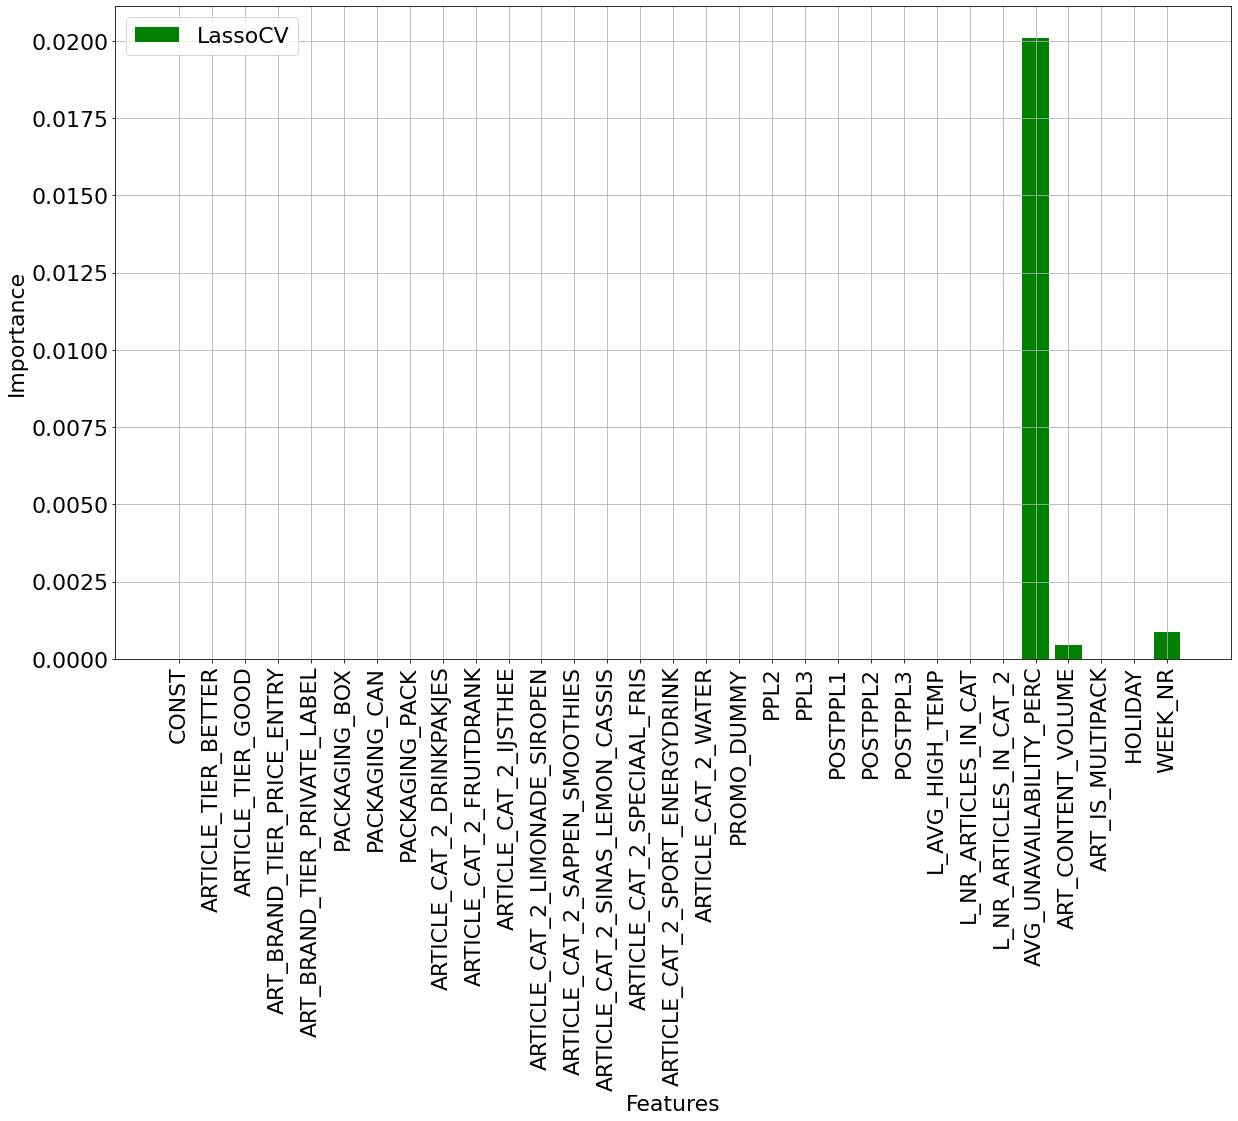

In [87]:
lasso_importance = np.abs(lasso_l.coef_)
rf_importance = rfor_l.feature_importances_
xgb_importance = xgbr_l.feature_importances_

# Plot the feature importances
plt.figure(figsize=(20, 12))
plt.grid()
plt.bar(x_lasso_train.columns, lasso_importance, label='LassoCV', color='g')
# plt.bar(x_lasso_train.columns, rf_importance, alpha=0.7, label='Random Forest')
# plt.bar(x_lasso_train.columns, xgb_importance, alpha=0.5, label='XGBoost')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.legend()
# 
plt.show()


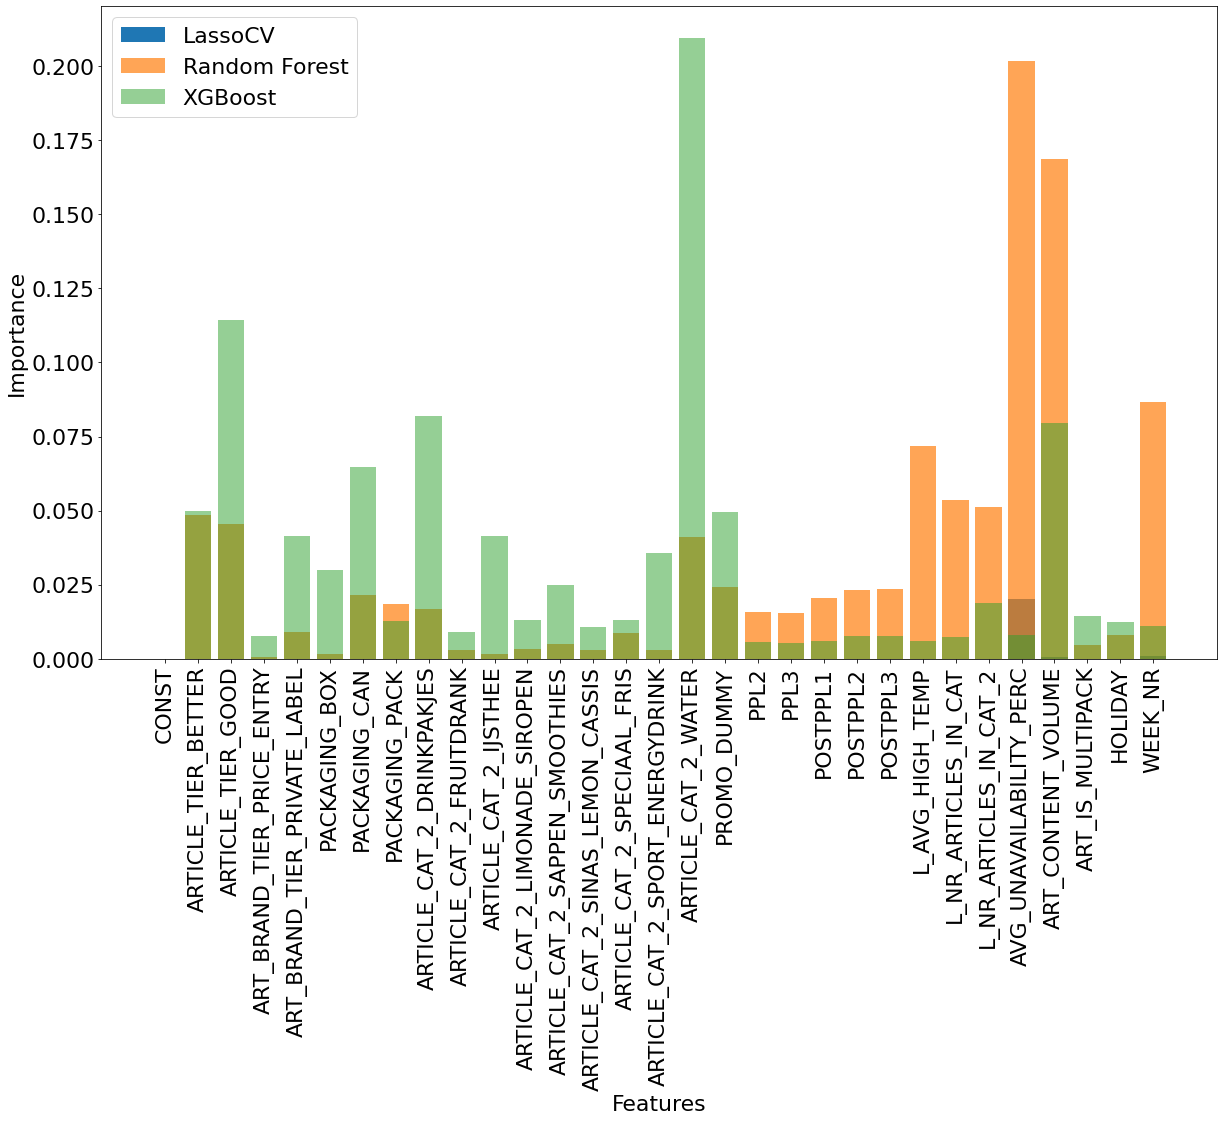

In [70]:
lasso_importance = np.abs(lasso_l.coef_)
rf_importance = rfor_l.feature_importances_
xgb_importance = xgbr_l.feature_importances_

# Plot the feature importances
plt.figure(figsize=(20, 12))
plt.bar(x_lasso_train.columns, lasso_importance, label='LassoCV')
plt.bar(x_lasso_train.columns, rf_importance, alpha=0.7, label='Random Forest')
plt.bar(x_lasso_train.columns, xgb_importance, alpha=0.5, label='XGBoost')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.legend()
plt.show()


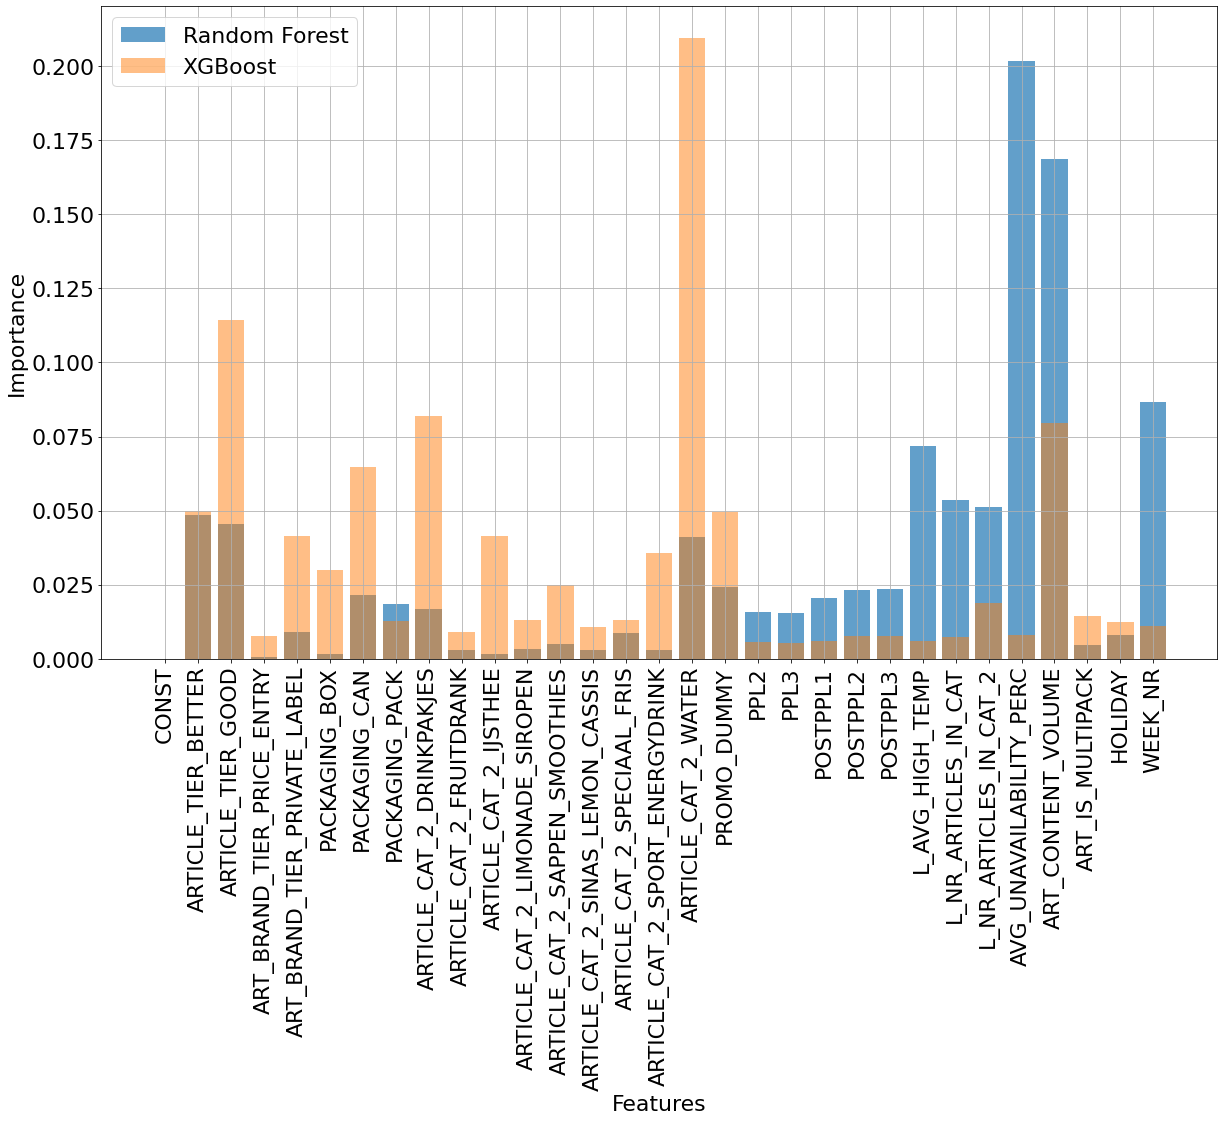

In [71]:
lasso_importance = np.abs(lasso_l.coef_)/np.sum(np.abs(lasso_l.coef_))
rf_importance = rfor_l.feature_importances_/np.sum(rfor_l.feature_importances_)
xgb_importance = xgbr_l.feature_importances_/np.sum(xgbr_l.feature_importances_)

plt.rcParams.update({'font.size': 22})
# Plot the feature importances
plt.figure(figsize=(20, 12))
# plt.bar(x_lasso_train.columns, lasso_importance, label='Lasso')
plt.bar(x_lasso_train.columns, rf_importance, alpha=0.7, label='Random Forest')
plt.bar(x_lasso_train.columns, xgb_importance, alpha=0.5, label='XGBoost')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.legend()
plt.grid()
plt.show()


In [72]:
# ml_l_tune.fit(x_lasso_train,y_lasso_train)
# rfor_l.fit(x_lasso_train,y_lasso_train)
# xgbr_l.fit(x_lasso_train,y_lasso_train)
# # Get the feature importances for each model
# lasso_importance = np.abs(ml_l_tune.coef_)
# rf_importance = rfor_l.feature_importances_
# xgb_importance = xgbr_l.feature_importances_

feature_names=x_lasso_train.columns

# Print the feature importances for each model
print("LassoCV feature importances:")
for i in range(len(feature_names)):
    print(f"{feature_names[i]}: {lasso_importance[i]}")
print("\nRandom Forest feature importances:")
for i in range(len(feature_names)):
    print(f"{feature_names[i]}: {rf_importance[i]}")
print("\nXGBoost feature importances:")
for i in range(len(feature_names)):
    print(f"{feature_names[i]}: {xgb_importance[i]}")


LassoCV feature importances:
CONST: 0.0
ARTICLE_TIER_BETTER: 0.0
ARTICLE_TIER_GOOD: 0.0
ART_BRAND_TIER_PRICE_ENTRY: 0.0
ART_BRAND_TIER_PRIVATE_LABEL: 0.0
PACKAGING_BOX: 0.0
PACKAGING_CAN: 0.0
PACKAGING_PACK: 0.0
ARTICLE_CAT_2_DRINKPAKJES: 0.0
ARTICLE_CAT_2_FRUITDRANK: 0.0
ARTICLE_CAT_2_IJSTHEE: 0.0
ARTICLE_CAT_2_LIMONADE_SIROPEN: 0.0
ARTICLE_CAT_2_SAPPEN_SMOOTHIES: 0.0
ARTICLE_CAT_2_SINAS_LEMON_CASSIS: 0.0
ARTICLE_CAT_2_SPECIAAL_FRIS: 0.0
ARTICLE_CAT_2_SPORT_ENERGYDRINK: 0.0
ARTICLE_CAT_2_WATER: 0.0
PROMO_DUMMY: 0.0
PPL2: 0.0
PPL3: 0.0
POSTPPL1: 0.0
POSTPPL2: 0.0
POSTPPL3: 0.0
L_AVG_HIGH_TEMP: 0.0
L_NR_ARTICLES_IN_CAT: 0.0
L_NR_ARTICLES_IN_CAT_2: 0.0
AVG_UNAVAILABILITY_PERC: 0.9380672531405091
ART_CONTENT_VOLUME: 0.021338997162979788
ART_IS_MULTIPACK: 0.0
HOLIDAY: 0.0
WEEK_NR: 0.040593749696511035

Random Forest feature importances:
CONST: 0.0
ARTICLE_TIER_BETTER: 0.04848354477512103
ARTICLE_TIER_GOOD: 0.04555242655723298
ART_BRAND_TIER_PRICE_ENTRY: 0.0007265459398989803
ART_BRAND_TIER

Model for Price:

In [73]:
lasso_r.fit(x_lasso_train,p_lasso_train)
rfor_r.fit(x_lasso_train,p_lasso_train)
xgbr_r.fit(x_lasso_train,p_lasso_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

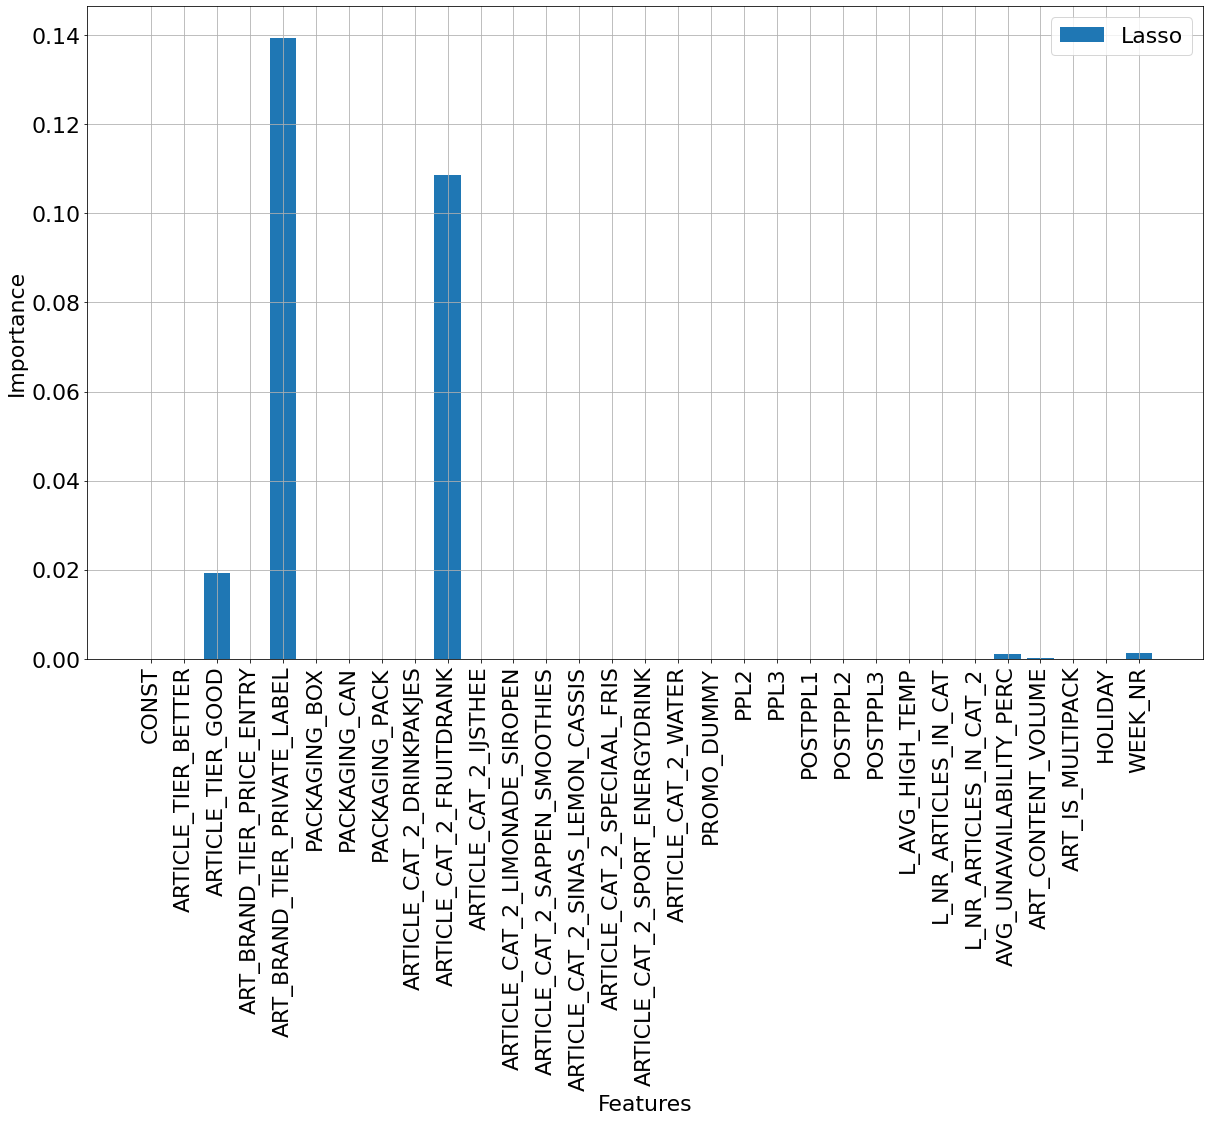

In [74]:
lasso_importance = np.abs(lasso_r.coef_)
rf_importance = rfor_r.feature_importances_
xgb_importance = xgbr_r.feature_importances_

# Plot the feature importances
plt.figure(figsize=(20, 12))
plt.bar(x_lasso_train.columns, lasso_importance, label='Lasso')
# plt.bar(x_lasso_train.columns, rf_importance, alpha=0.7, label='Random Forest')
# plt.bar(x_lasso_train.columns, xgb_importance, alpha=0.5, label='XGBoost')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.legend()
plt.grid()
plt.show()


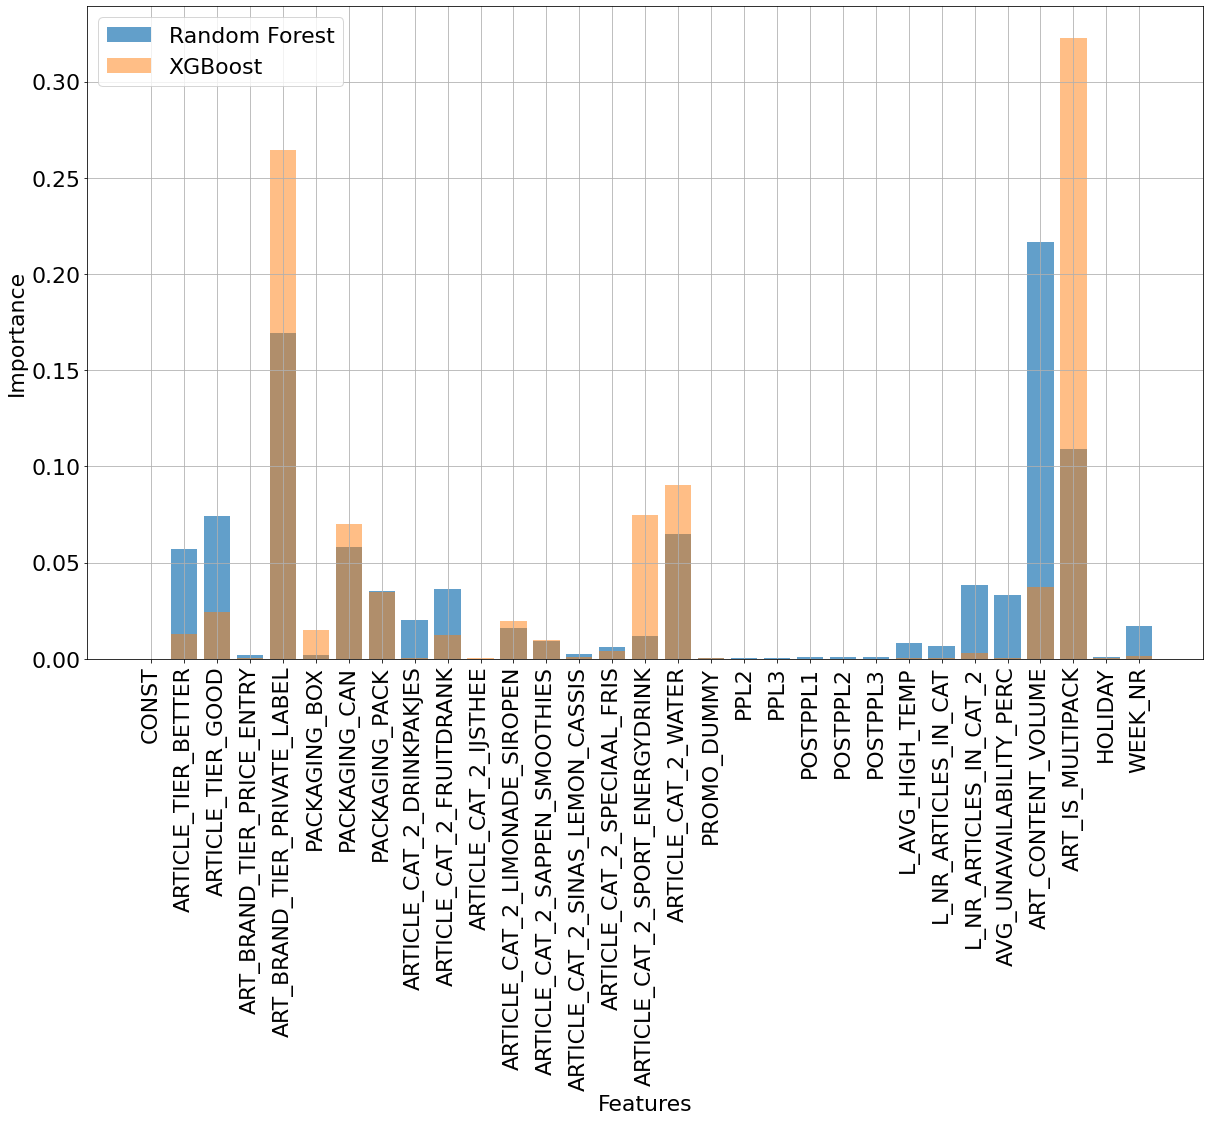

In [75]:
lasso_importance = np.abs(lasso_r.coef_)/np.sum(np.abs(lasso_r.coef_))
rf_importance = rfor_r.feature_importances_/np.sum(rfor_r.feature_importances_)
xgb_importance = xgbr_r.feature_importances_/np.sum(xgbr_r.feature_importances_)

# Plot the feature importances
plt.figure(figsize=(20, 12))
# plt.bar(x_lasso_train.columns, lasso_importance, label='Lasso')
plt.bar(x_lasso_train.columns, rf_importance, alpha=0.7, label='Random Forest')
plt.bar(x_lasso_train.columns, xgb_importance, alpha=0.5, label='XGBoost')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.legend()
plt.grid()
plt.show()


In [76]:
# lasso_r.fit(x_lasso_train,p_lasso_train)
# rfor_r.fit(x_lasso_train,p_lasso_train)
# xgbr_r.fit(x_lasso_train,p_lasso_train)

# # Get the feature importances for each model
# lasso_importance = np.abs(lasso_r.coef_)
# rf_importance = rfor_r.feature_importances_
# xgb_importance = xgbr_r.feature_importances_

feature_names=x_lasso_train.columns

# Print the feature importances for each model
print("LassoCV feature importances:")
for i in range(len(feature_names)):
    print(f"{feature_names[i]}: {lasso_importance[i]}")
print("\nRandom Forest feature importances:")
for i in range(len(feature_names)):
    print(f"{feature_names[i]}: {rf_importance[i]}")
print("\nXGBoost feature importances:")
for i in range(len(feature_names)):
    print(f"{feature_names[i]}: {xgb_importance[i]}")


LassoCV feature importances:
CONST: 0.0
ARTICLE_TIER_BETTER: 0.0
ARTICLE_TIER_GOOD: 0.07157392545101487
ART_BRAND_TIER_PRICE_ENTRY: 0.0
ART_BRAND_TIER_PRIVATE_LABEL: 0.5163504273569228
PACKAGING_BOX: 0.0
PACKAGING_CAN: 0.0
PACKAGING_PACK: 0.0
ARTICLE_CAT_2_DRINKPAKJES: 0.0
ARTICLE_CAT_2_FRUITDRANK: 0.4023151758696548
ARTICLE_CAT_2_IJSTHEE: 0.0
ARTICLE_CAT_2_LIMONADE_SIROPEN: 0.0
ARTICLE_CAT_2_SAPPEN_SMOOTHIES: 0.0
ARTICLE_CAT_2_SINAS_LEMON_CASSIS: 0.0
ARTICLE_CAT_2_SPECIAAL_FRIS: 0.0
ARTICLE_CAT_2_SPORT_ENERGYDRINK: 0.0
ARTICLE_CAT_2_WATER: 0.0
PROMO_DUMMY: 0.0
PPL2: 0.0
PPL3: 0.0
POSTPPL1: 0.0
POSTPPL2: 0.0
POSTPPL3: 0.0
L_AVG_HIGH_TEMP: 0.0
L_NR_ARTICLES_IN_CAT: 0.0
L_NR_ARTICLES_IN_CAT_2: 0.0
AVG_UNAVAILABILITY_PERC: 0.004270627636810769
ART_CONTENT_VOLUME: 0.0005378843037161264
ART_IS_MULTIPACK: 0.0
HOLIDAY: 0.0
WEEK_NR: 0.004951959381880545

Random Forest feature importances:
CONST: 0.0
ARTICLE_TIER_BETTER: 0.05728805924217754
ARTICLE_TIER_GOOD: 0.0741128754440733
ART_BRAND_TIER_P

Feat imp for Z


In [77]:
lasso_m.fit(x_lasso_train,z_lasso_train)
rfor_m.fit(x_lasso_train,z_lasso_train)
xgbr_m.fit(x_lasso_train,z_lasso_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

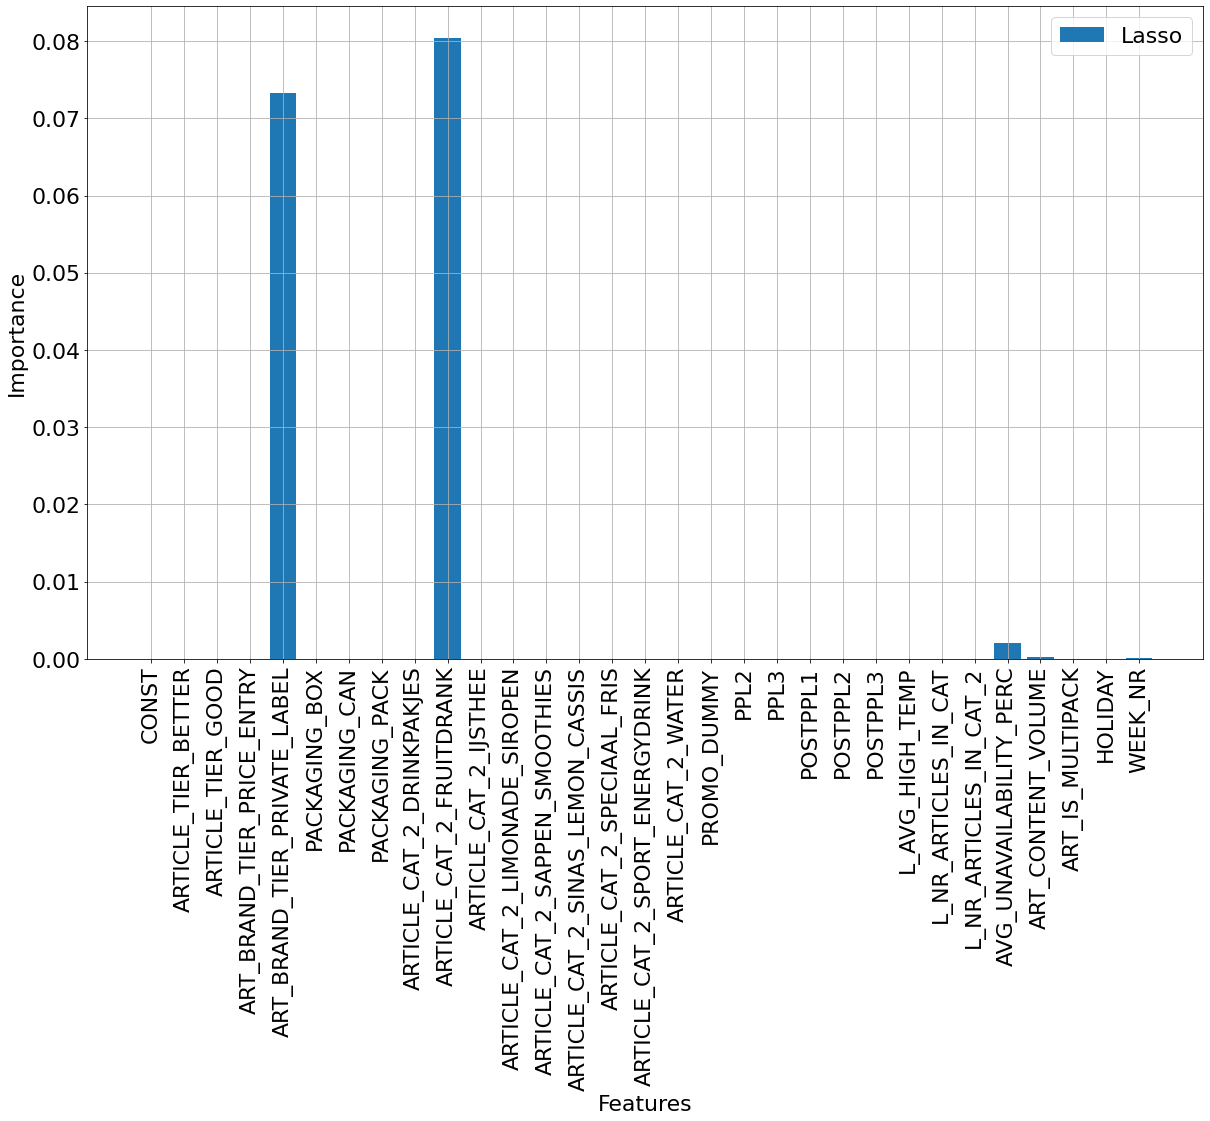

In [78]:
lasso_importance = np.abs(lasso_m.coef_)
rf_importance = rfor_m.feature_importances_
xgb_importance = xgbr_m.feature_importances_

# Plot the feature importances
plt.figure(figsize=(20, 12))
plt.bar(x_lasso_train.columns, lasso_importance, label='Lasso')
# plt.bar(x_lasso_train.columns, rf_importance, alpha=0.7, label='Random Forest')
# plt.bar(x_lasso_train.columns, xgb_importance, alpha=0.5, label='XGBoost')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.legend()
plt.grid()
plt.show()


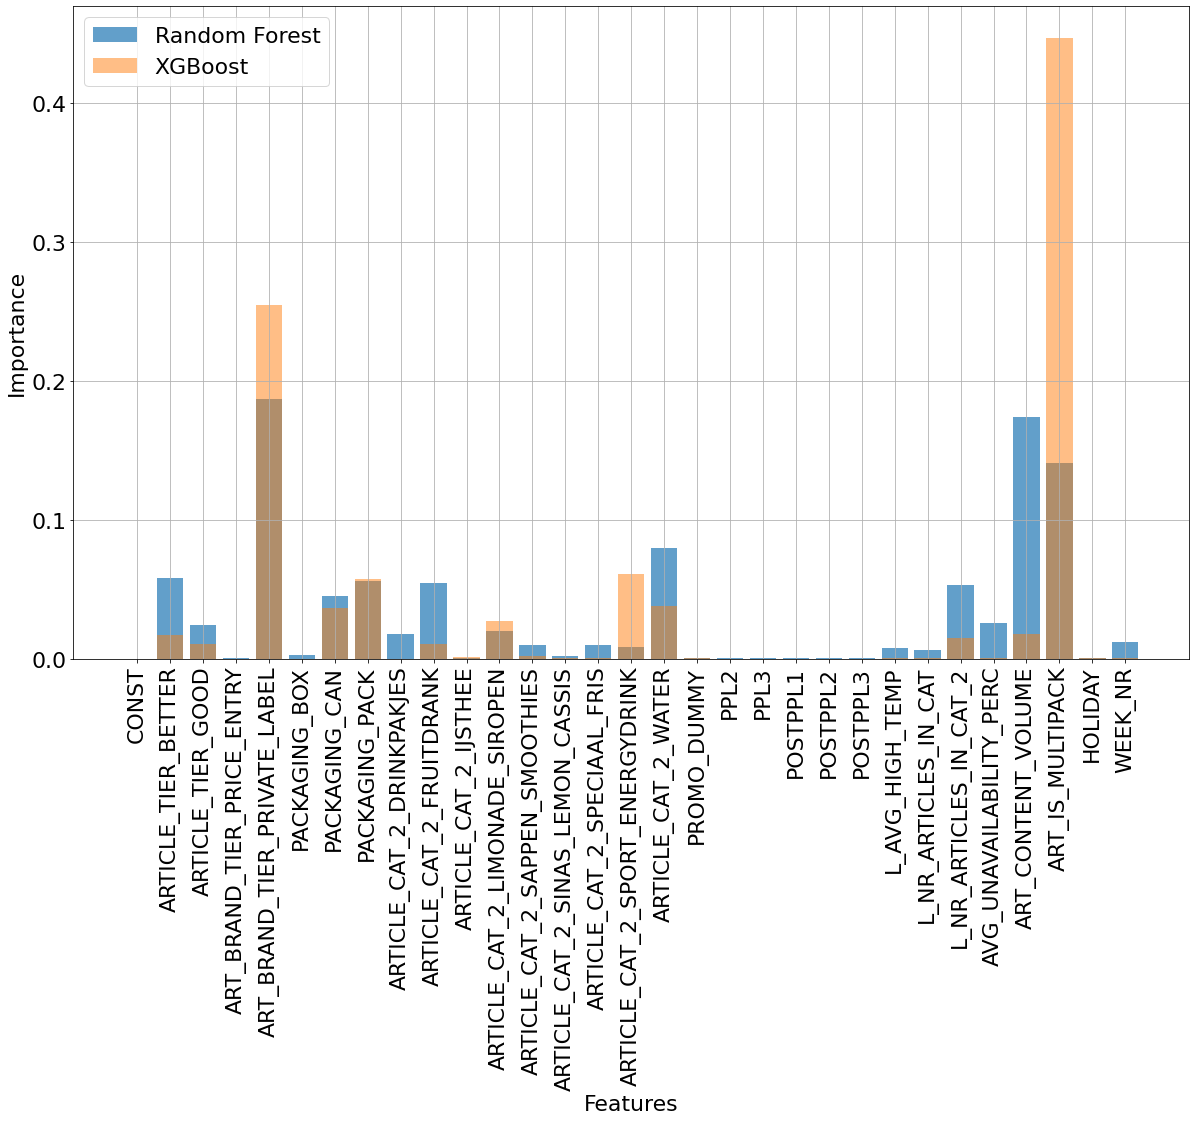

In [79]:
lasso_importance = np.abs(lasso_m.coef_)/np.sum(np.abs(lasso_m.coef_))
rf_importance = rfor_m.feature_importances_/np.sum(rfor_m.feature_importances_)
xgb_importance = xgbr_m.feature_importances_/np.sum(xgbr_m.feature_importances_)

# Plot the feature importances
plt.figure(figsize=(20, 12))
# plt.bar(x_lasso_train.columns, lasso_importance, label='Lasso')
plt.bar(x_lasso_train.columns, rf_importance, alpha=0.7, label='Random Forest')
plt.bar(x_lasso_train.columns, xgb_importance, alpha=0.5, label='XGBoost')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.legend()
plt.grid()
plt.show()


In [80]:
# lasso_r.fit(x_lasso_train,p_lasso_train)
# rfor_r.fit(x_lasso_train,p_lasso_train)
# xgbr_r.fit(x_lasso_train,p_lasso_train)

# # Get the feature importances for each model
# lasso_importance = np.abs(lasso_r.coef_)
# rf_importance = rfor_r.feature_importances_
# xgb_importance = xgbr_r.feature_importances_

feature_names=x_lasso_train.columns

# Print the feature importances for each model
print("LassoCV feature importances:")
for i in range(len(feature_names)):
    print(f"{feature_names[i]}: {lasso_importance[i]}")
print("\nRandom Forest feature importances:")
for i in range(len(feature_names)):
    print(f"{feature_names[i]}: {rf_importance[i]}")
print("\nXGBoost feature importances:")
for i in range(len(feature_names)):
    print(f"{feature_names[i]}: {xgb_importance[i]}")


LassoCV feature importances:
CONST: 0.0
ARTICLE_TIER_BETTER: 0.0
ARTICLE_TIER_GOOD: 0.0
ART_BRAND_TIER_PRICE_ENTRY: 0.0
ART_BRAND_TIER_PRIVATE_LABEL: 0.4695931325467028
PACKAGING_BOX: 0.0
PACKAGING_CAN: 0.0
PACKAGING_PACK: 0.0
ARTICLE_CAT_2_DRINKPAKJES: 0.0
ARTICLE_CAT_2_FRUITDRANK: 0.5155359954501196
ARTICLE_CAT_2_IJSTHEE: 0.0
ARTICLE_CAT_2_LIMONADE_SIROPEN: 0.0
ARTICLE_CAT_2_SAPPEN_SMOOTHIES: 0.0
ARTICLE_CAT_2_SINAS_LEMON_CASSIS: 0.0
ARTICLE_CAT_2_SPECIAAL_FRIS: 0.0
ARTICLE_CAT_2_SPORT_ENERGYDRINK: 0.0
ARTICLE_CAT_2_WATER: 0.0
PROMO_DUMMY: 0.0
PPL2: 0.0
PPL3: 0.0
POSTPPL1: 0.0
POSTPPL2: 0.0
POSTPPL3: 0.0
L_AVG_HIGH_TEMP: 0.0
L_NR_ARTICLES_IN_CAT: 0.0
L_NR_ARTICLES_IN_CAT_2: 0.0
AVG_UNAVAILABILITY_PERC: 0.013235131906023273
ART_CONTENT_VOLUME: 0.0011023948811742451
ART_IS_MULTIPACK: 0.0
HOLIDAY: 0.0
WEEK_NR: 0.0005333452159799704

Random Forest feature importances:
CONST: 0.0
ARTICLE_TIER_BETTER: 0.05820867076539108
ARTICLE_TIER_GOOD: 0.024174689971302992
ART_BRAND_TIER_PRICE_ENTRY: 0